In [1]:
import sys
import os
import shutil
import datetime
import re
import pandas as pd
from collections import Counter
sys.path.append(os.path.abspath("/home/jose/Dropbox/Doktorarbeit/"))
from reading_robot import load_data, tei2text, text2features, classify, process_labels, describe_data,feature_analysis, cull_data, st_tests, metadata2numbers, cluster, call_stylo, prepare_subcorpus, genre_as_graph
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
%matplotlib inline
from shutil import copyfile
import numpy as np
import networkx as nx
import pygraphviz

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# Getting Data

In [2]:
ne_dir = "/home/jose/Dropbox/Doktorarbeit/novelasespanolas/"

In [3]:
wdir = "/home/jose/Dropbox/Doktorarbeit/ne_data/chap8/"

## Getting Files

In [4]:
copyfile(ne_dir + "exported/tags_ling_pos_diff_mw_ord_ent_70000_T.parquet", wdir +"tags_ling_pos_diff_mw_ord_ent_70000_T.parquet")
copyfile(ne_dir+"metadata_beta-opt-obl-structure.csv", wdir + "metadata_beta-opt-obl-structure.csv")
copyfile(ne_dir+"metadata_recategorized.csv", wdir + "metadata_recategorized.csv")
copyfile("/home/jose/Dropbox/Doktorarbeit/ne_data/chap5_1/labels_agreement.csv", wdir + "labels_agreement.csv")
copyfile(ne_dir+"rel_quantified_labels.csv", wdir + "rel_quantified_labels.csv")

copyfile("/home/jose/Dropbox/Doktorarbeit/ne_data/chap7_1/combined_results_metadata.csv", wdir + "combined_results_metadata.csv")


'/home/jose/Dropbox/Doktorarbeit/ne_data/chap8/combined_results_metadata.csv'

## Getting Metadata

In [5]:
metadata_df = pd.read_csv(wdir+"metadata_beta-opt-obl-structure.csv",index_col=0,sep=",").fillna(0)
metadata_df.shape

(358, 177)

In [6]:
metadata_df.head()

idno author.name         title  year supergenre   genre  \
ne0001  ne0001      Baroja     Mayorazgo  1903  narrative  novela   
ne0002  ne0002      Galdos  Misericordia  1889  narrative  novela   
ne0003  ne0003      Galdos       Nazarin  1895  narrative  novela   
ne0004  ne0004      Galdos         Halma  1895  narrative  novela   
ne0005  ne0005      Galdos      Tristana  1892  narrative  novela   

       subgenre.cligs.important author.country  author.viaf author.bne  ...    \
ne0001                  realist          Spain   36912891.0   XX842743  ...     
ne0002                  realist          Spain   71395987.0  XX1014802  ...     
ne0003                  realist          Spain   71395987.0  XX1014802  ...     
ne0004                  realist          Spain   71395987.0  XX1014802  ...     
ne0005            bildungsroman          Spain   71395987.0  XX1014802  ...     

       am.wnlex.noun.Topss am.wnlex.noun.relations am.wnlex.noun.attributes  \
ne0001                 121                      13                      483   
ne0002                 239                      39                      821   
ne0003                 253                      17                      725   
ne0004                 288                      24                     1061   
ne0005                 191                      17                      705   

       am.wnlex.verb.emotions am.wnlex.noun.locations am.wnlex.noun.events  \
ne0001                    200                     312                  177   
ne0002                    314                     336                  355   
ne0003                    396                     301                  327   
ne0004                    424                     282                  248   
ne0005                    456                     174                  229   

       am.wnlex.verb.contacts am.wnlex.xxxs am.wnlex.verb.changes decade  
ne0001                    518         41371                   655   1900  
ne0002                    684         70169                   764   1880  
ne0003                    498         54401                   572   1890  
ne0004                    450         60648                   553   1890  
ne0005                    415         43359                   446   1890  

[5 rows x 177 columns]

In [7]:
independent_sources_genre = ['subgenre.cligs', 'subgenre.lithist.MdLE', 'subgenre.lithist.HdLE', 'subgenre.edit.epublibre', 'subgenre.edit.amazon','subgenre.subtitle.bne','subgenre.cluster']

Obtaining number of sources:

In [8]:
metadata_df["number.sources"] = 0
for index, row in metadata_df.iterrows():
    i = 0
    for independent_source_genre in independent_sources_genre:

        if row[independent_source_genre] != 0:
            i += 1
    metadata_df.loc[index,"number.sources"] = i
    

In [9]:
metadata_df[independent_sources_genre+["number.sources"]]

subgenre.cligs  \
ne0001              naturalist,sentimental,social,realist   
ne0002                          naturalist,social,realist   
ne0003                naturalist,social,spiritual,realist   
ne0004               sentimental,social,spiritual,realist   
ne0005  naturalist,realist,sentimental,social,spiritua...   
ne0006  naturalist,realist,sentimental,social,spiritua...   
ne0007                   naturalist,realist,social,erotic   
ne0008                              realist,social,erotic   
ne0009  naturalist,realist,sentimental,social,bildungs...   
ne0010                               social,philosophical   
ne0011    memoir,realist,sentimental,social,philosophical   
ne0013               memoir,modernist,realist,sentimental   
ne0014     adventure,memoir,modernist,realist,sentimental   
ne0015               memoir,modernist,realist,sentimental   
ne0016    historical,memoir,modernist,realist,sentimental   
ne0017  fantastic,modernist,naturalist,sentimental,soc...   
ne0018                          crime-fiction,sentimental   
ne0019                          naturalist,social,realist   
ne0020      adventure,realist,social,war-novel,historical   
ne0021      adventure,realist,social,war-novel,historical   
ne0022      adventure,realist,social,war-novel,historical   
ne0023                                      philosophical   
ne0024  naturalist,philosophical,realist,social,bildun...   
ne0025                                      erotic,comedy   
ne0026                  realist,sentimental,social,erotic   
ne0027                          naturalist,social,realist   
ne0028              naturalist,sentimental,social,realist   
ne0029       memoir,naturalist,realist,sentimental,social   
ne0030        political-fiction,realist,social,historical   
ne0031                          naturalist,social,realist   
...                                                   ...   
ne0360          science-fiction,sentimental,philosophical   
ne0361                modernist,symbolic,autobiographical   
ne0362                                   comedy,adventure   
ne0363                    costumbrista,sentimental,social   
ne0364                 historical,philosophical,war-novel   
ne0365  philosophical,political-fiction,symbolic,fanta...   
ne0370                 philosophical,war-novel,historical   
ne0373                               crime-fiction,erotic   
ne0378                                      comedy,social   
ne0379  historical,philosophical,psicological,realist,...   
ne0380                          crime-fiction,vanguardist   
ne0381                   comedy,sentimental,philosophical   
ne0382                                     realist,social   
ne0384                          naturalist,social,realist   
ne0385                                realist,sentimental   
ne0387                   bildungsroman,realist,historical   
ne0388                       philosophical,realist,social   
ne0390                                     realist,social   
ne0391                   bildungsroman,social,sentimental   
ne0392                   bildungsroman,social,sentimental   
ne0393  autobiographical,philosophical,realist,bildung...   
ne0394       autobiographical,philosophical,bildungsroman   
ne0395                                 social,sentimental   
ne0396                                     realist,social   
ne0397                              modernist,sentimental   
ne0398                         sentimental,social,realist   
ne0399                  antireligous,philosophical,social   
ne0401                          vanguardist,philosophical   
ne0403                                 social,sentimental   
ne0404                              comedy,realist,social   

                                    subgenre.lithist.MdLE  \
ne0001                                                  0   
ne0002                                    novela de tesis   
ne0003                              novela espiritualista   
ne0004          

In [10]:
semantic_subgenres_lt = ["autobiografía","aventura","biografía","costumbrista","diálogo","educación","episodio nacional","erótica","espiritual","fantástico","filosófica","greguería","guerra","histórica","humor","memorias","modernista","naturalista","nivola","poética","psicológica","realista","social","bucólica","mono-diálogo","ficción-literaria"]

In [11]:
rel_quantified_subgenres_df = pd.read_csv(wdir+"rel_quantified_labels.csv",sep="\t", index_col=0)

In [12]:
rel_quantified_subgenres_df.head(20)

autobiografía  aventura  biografía  costumbrista  diálogo  educación  \
ne0001            0.0  0.333333        0.0           0.0      0.0       0.00   
ne0002            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0003            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0004            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0005            0.0  0.000000        0.0           0.0      0.0       0.25   
ne0006            0.0  0.000000        0.0           0.0      0.0       0.25   
ne0007            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0008            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0009            0.0  0.000000        0.0           0.0      0.0       0.20   
ne0010            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0011            0.0  0.000000        0.0           0.0      0.0       0.40   
ne0013            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0014            0.0  0.200000        0.0           0.0      0.0       0.00   
ne0015            0.0  0.200000        0.0           0.0      0.0       0.00   
ne0016            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0017            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0018            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0019            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0020            0.0  0.500000        0.0           0.0      0.0       0.00   
ne0021            0.0  0.500000        0.0           0.0      0.0       0.00   

        episodio nacional  erótica  espiritual  fantástico        ...          \
ne0001                0.0      0.0         0.0        0.00        ...           
ne0002                0.0      0.0         0.0        0.25        ...           
ne0003                0.0      0.0         0.5        0.00        ...           
ne0004                0.0      0.0         0.5        0.00        ...           
ne0005                0.0      0.0         0.5        0.00        ...           
ne0006                0.0      0.0         0.5        0.00        ...           
ne0007                0.0      0.2         0.0        0.00        ...           
ne0008                0.0      0.5         0.0        0.00        ...           
ne0009                0.0      0.0         0.0        0.00        ...           
ne0010                0.0      0.0         0.0        0.00        ...           
ne0011                0.0      0.0         0.0        0.00        ...           
ne0013                0.0      0.0         0.0        0.00        ...           
ne0014                0.0      0.0         0.0        0.00        ...           
ne0015                0.0      0.0         0.0        0.00        ...           
ne0016                0.0      0.0         0.0        0.00        ...           
ne0017                0.0      0.0         0.2        0.20        ...           
ne0018                0.0      0.0         0.0        0.00        ...           
ne0019                0.0      0.0         0.0        0.00        ...           
ne0020                0.0      0.0         0.0        0.00        ...           
ne0021                0.0      0.0         0.0        0.00        ...           

        modernista  naturalista  nivola  poética  psicológica  realista  \
ne0001         0.0     0.333333     0.0      0.0          0.0  0.333333   
ne0002         0.0     0.250000     0.0      0.0          0.0  0.500000   
ne0003         0.0     0.250000     0.0      0.0          0.0  0.250000   
ne0004         0.0     0.000000     0.0      0.0          0.0  0.500000   
ne0005         0.0     0.250000     0.0      0.0          0.0  0.500000   
ne0006         0.0     0.250000     0.0      0.0          0.0  0.500000   
ne0007         0.0     0.600000     0.0      0.0          0.0  0.200000   
ne0008         0.0     0.

In [13]:
metadata_df.loc[metadata_df["author.name"]=="Valle"]

idno author.name               title  year   supergenre   genre  \
ne0013  ne0013       Valle         SonataOtono  1902    narrative  novela   
ne0014  ne0014       Valle         SonataEstio  1903    narrative  novela   
ne0015  ne0015       Valle     SonataPrimavera  1904    narrative  novela   
ne0016  ne0016       Valle      SonataInvierno  1905    narrative  novela   
ne0017  ne0017       Valle      FlordeSantidad  1904    narrative  novela   
ne0020  ne0020       Valle       CruzadosCausa  1908    narrative  novela   
ne0021  ne0021       Valle   ResplandorHoguera  1909    narrative  novela   
ne0022  ne0022       Valle    GerifaltesAntano  1909    narrative  novela   
ne0023  ne0023       Valle  LamparaMaravillosa  1916  non-fiction       ?   
ne0030  ne0030       Valle      TiranoBanderas  1926    narrative  novela   
ne0033  ne0033       Valle               Corte  1927    narrative  novela   
ne0035  ne0035       Valle                Viva  1928    narrative  novela   
ne0036  ne0036       Valle                Baza  1932    narrative  novela   
ne0037  ne0037       Valle          MediaNoche  1917    narrative       ?   

       subgenre.cligs.important author.country  author.viaf author.bne  \
ne0013                   memoir          Spain   68936773.0  XX1055436   
ne0014                   memoir          Spain   68936773.0  XX1055436   
ne0015                   memoir          Spain   68936773.0  XX1055436   
ne0016                   memoir          Spain   68936773.0  XX1055436   
ne0017                   social          Spain   68936773.0  XX1055436   
ne0020               historical          Spain   68936773.0  XX1055436   
ne0021               historical          Spain   68936773.0  XX1055436   
ne0022               historical          Spain   68936773.0  XX1055436   
ne0023            philosophical          Spain   68936773.0  XX1055436   
ne0030               historical          Spain   68936773.0  XX1055436   
ne0033               historical          Spain   68936773.0  XX1055436   
ne0035               historical          Spain   68936773.0  XX1055436   
ne0036               historical          Spain   68936773.0  XX1055436   
ne0037               historical          Spain   68936773.0  XX1055436   

            ...       am.wnlex.noun.relations am.wnlex.noun.attributes  \
ne0013      ...                             1                      222   
ne0014      ...                             4                      261   
ne0015      ...                             0                      253   
ne0016      ...                             3                      296   
ne0017      ...                             0                      180   
ne0020      ...                             2                      204   
ne0021      ...                             1                      257   
ne0022      ...                             2                      206   
ne0023      ...                             1                       38   
ne0030      ...                            19                      422   
ne0033      ...                            13                      657   
ne0035      ...                             9                      774   
ne0036      ...                             9                      505   
ne0037      ...                             1                      119   

       am.wnlex.verb.emotions am.wnlex.noun.locations am.wnlex.noun.events  \
ne0013                    137                      86                   76   
ne0014                    121                     103                   85   
ne0015                    116                     103                   86   
ne0016                    162                      96                  108   
ne0017                     56                     145                   83   
ne0020                     79                      94                   75   
ne0021                     53                     134                   80   
ne0022  

In [14]:
rel_quantified_subgenres_df.loc["ne0037"]

autobiografía        0.00
aventura             0.00
biografía            0.00
costumbrista         0.00
diálogo              0.00
educación            0.00
episodio nacional    0.00
erótica              0.00
espiritual           0.00
fantástico           0.00
filosófica           0.00
greguería            0.00
guerra               0.25
histórica            0.25
humor                0.00
memorias             0.00
modernista           0.00
naturalista          0.00
nivola               0.00
poética              0.00
psicológica          0.00
realista             0.25
social               0.25
bucólica             0.25
mono-diálogo         0.00
ficción-literaria    0.25
Name: ne0037, dtype: float64

In [15]:
bool_quantified_subgenre_df = (rel_quantified_subgenres_df > 0).astype(int)
bool_quantified_subgenre_df.head(15)

autobiografía  aventura  biografía  costumbrista  diálogo  educación  \
ne0001              0         1          0             0        0          0   
ne0002              0         0          0             0        0          0   
ne0003              0         0          0             0        0          0   
ne0004              0         0          0             0        0          0   
ne0005              0         0          0             0        0          1   
ne0006              0         0          0             0        0          1   
ne0007              0         0          0             0        0          0   
ne0008              0         0          0             0        0          0   
ne0009              0         0          0             0        0          1   
ne0010              0         0          0             0        0          0   
ne0011              0         0          0             0        0          1   
ne0013              0         0          0             0        0          0   
ne0014              0         1          0             0        0          0   
ne0015              0         1          0             0        0          0   
ne0016              0         0          0             0        0          0   

        episodio nacional  erótica  espiritual  fantástico        ...          \
ne0001                  0        0           0           0        ...           
ne0002                  0        0           0           1        ...           
ne0003                  0        0           1           0        ...           
ne0004                  0        0           1           0        ...           
ne0005                  0        0           1           0        ...           
ne0006                  0        0           1           0        ...           
ne0007                  0        1           0           0        ...           
ne0008                  0        1           0           0        ...           
ne0009                  0        0           0           0        ...           
ne0010                  0        0           0           0        ...           
ne0011                  0        0           0           0        ...           
ne0013                  0        0           0           0        ...           
ne0014                  0        0           0           0        ...           
ne0015                  0        0           0           0        ...           
ne0016                  0        0           0           0        ...           

        modernista  naturalista  nivola  poética  psicológica  realista  \
ne0001           0            1       0        0            0         1   
ne0002           0            1       0        0            0         1   
ne0003           0            1       0        0            0         1   
ne0004           0            0       0        0            0         1   
ne0005           0            1       0        0            0         1   
ne0006           0            1       0        0            0         1   
ne0007           0            1       0        0            0         1   
ne0008           0            0       0        0            0         1   
ne0009           0            1       0        0            0         1   
ne0010           0            0       0        0            0         0   
ne0011           0            1       0        0            0         1   
ne0013           1            0       0        0            0         1   
ne0014           1            0       0        0            0         1   
ne0015           1            0       0        0            0         1   
ne0016           1            0       0        0            0         1   

        social  bucólica  mono-diálogo  ficción-literaria  
ne0001       1         0             0                  1  
ne0002       1         0             0                  1  
ne0003       1         0             0           

Concatenating the metadata with the relative number of labels:

In [16]:
new_metadata_df = pd.concat([metadata_df, rel_quantified_subgenres_df], axis=1)
new_metadata_df = new_metadata_df.loc[(new_metadata_df["genre.analyzed"]=="novela")]
new_metadata_df.shape

(352, 204)

In [17]:
new_metadata_df["mean.prop.subgenres"] = rel_quantified_subgenres_df.mean(axis=1)

In [18]:
new_metadata_df.head()

idno author.name         title  year supergenre   genre  \
ne0001  ne0001      Baroja     Mayorazgo  1903  narrative  novela   
ne0002  ne0002      Galdos  Misericordia  1889  narrative  novela   
ne0003  ne0003      Galdos       Nazarin  1895  narrative  novela   
ne0004  ne0004      Galdos         Halma  1895  narrative  novela   
ne0005  ne0005      Galdos      Tristana  1892  narrative  novela   

       subgenre.cligs.important author.country  author.viaf author.bne  \
ne0001                  realist          Spain   36912891.0   XX842743   
ne0002                  realist          Spain   71395987.0  XX1014802   
ne0003                  realist          Spain   71395987.0  XX1014802   
ne0004                  realist          Spain   71395987.0  XX1014802   
ne0005            bildungsroman          Spain   71395987.0  XX1014802   

               ...         naturalista nivola poética psicológica  realista  \
ne0001         ...            0.333333    0.0     0.0         0.0  0.333333   
ne0002         ...            0.250000    0.0     0.0         0.0  0.500000   
ne0003         ...            0.250000    0.0     0.0         0.0  0.250000   
ne0004         ...            0.000000    0.0     0.0         0.0  0.500000   
ne0005         ...            0.250000    0.0     0.0         0.0  0.500000   

          social bucólica mono-diálogo ficción-literaria mean.prop.subgenres  
ne0001  0.333333      0.0          0.0          0.333333            0.064103  
ne0002  0.250000      0.0          0.0          0.250000            0.067308  
ne0003  0.250000      0.0          0.0          0.250000            0.057692  
ne0004  0.250000      0.0          0.0          0.250000            0.057692  
ne0005  0.250000      0.0          0.0          0.250000            0.076923  

[5 rows x 205 columns]

Separting the metadata of the entire corpus and the metadata of the version of the CoNSSA-canon:

In [19]:
new_metadata_canon_df = new_metadata_df.loc[new_metadata_df["CoNSSA.canon"]==True]

In [20]:
new_metadata_canon_df.head()

idno author.name         title  year supergenre   genre  \
ne0002  ne0002      Galdos  Misericordia  1889  narrative  novela   
ne0003  ne0003      Galdos       Nazarin  1895  narrative  novela   
ne0004  ne0004      Galdos         Halma  1895  narrative  novela   
ne0006  ne0006      Galdos         Angel  1891  narrative  novela   
ne0009  ne0009      Galdos   Desheredada  1881  narrative  novela   

       subgenre.cligs.important author.country  author.viaf author.bne  \
ne0002                  realist          Spain   71395987.0  XX1014802   
ne0003                  realist          Spain   71395987.0  XX1014802   
ne0004                  realist          Spain   71395987.0  XX1014802   
ne0006            bildungsroman          Spain   71395987.0  XX1014802   
ne0009            bildungsroman          Spain   71395987.0  XX1014802   

               ...         naturalista nivola poética psicológica realista  \
ne0002         ...                0.25    0.0     0.0         0.0     0.50   
ne0003         ...                0.25    0.0     0.0         0.0     0.25   
ne0004         ...                0.00    0.0     0.0         0.0     0.50   
ne0006         ...                0.25    0.0     0.0         0.0     0.50   
ne0009         ...                0.40    0.0     0.0         0.0     0.40   

       social bucólica mono-diálogo ficción-literaria mean.prop.subgenres  
ne0002   0.25      0.0          0.0              0.25            0.067308  
ne0003   0.25      0.0          0.0              0.25            0.057692  
ne0004   0.25      0.0          0.0              0.25            0.057692  
ne0006   0.25      0.0          0.0              0.25            0.076923  
ne0009   0.20      0.0          0.0              0.20            0.061538  

[5 rows x 205 columns]

In [21]:
bool_new_metadata_df = pd.concat([metadata_df, bool_quantified_subgenre_df ], axis=1)
bool_new_metadata_df = bool_new_metadata_df.loc[(bool_new_metadata_df["genre.analyzed"]=="novela")]
bool_new_metadata_df.shape

(352, 204)

In [22]:
bool_new_metadata_df.head()

idno author.name         title  year supergenre   genre  \
ne0001  ne0001      Baroja     Mayorazgo  1903  narrative  novela   
ne0002  ne0002      Galdos  Misericordia  1889  narrative  novela   
ne0003  ne0003      Galdos       Nazarin  1895  narrative  novela   
ne0004  ne0004      Galdos         Halma  1895  narrative  novela   
ne0005  ne0005      Galdos      Tristana  1892  narrative  novela   

       subgenre.cligs.important author.country  author.viaf author.bne  \
ne0001                  realist          Spain   36912891.0   XX842743   
ne0002                  realist          Spain   71395987.0  XX1014802   
ne0003                  realist          Spain   71395987.0  XX1014802   
ne0004                  realist          Spain   71395987.0  XX1014802   
ne0005            bildungsroman          Spain   71395987.0  XX1014802   

              ...        modernista naturalista nivola poética psicológica  \
ne0001        ...                 0           1      0       0           0   
ne0002        ...                 0           1      0       0           0   
ne0003        ...                 0           1      0       0           0   
ne0004        ...                 0           0      0       0           0   
ne0005        ...                 0           1      0       0           0   

       realista social bucólica mono-diálogo ficción-literaria  
ne0001        1      1        0            0                 1  
ne0002        1      1        0            0                 1  
ne0003        1      1        0            0                 1  
ne0004        1      1        0            0                 1  
ne0005        1      1        0            0                 1  

[5 rows x 204 columns]

In [23]:
texts_without_genre_lt = bool_new_metadata_df[semantic_subgenres_lt].sum(axis=1).sort_values().loc[bool_new_metadata_df[semantic_subgenres_lt].sum(axis=1).sort_values()== 0].index.tolist()


In [24]:
texts_split = ["ne0322","ne0323","ne0324","ne0326"]


In [25]:
metadata_recategorized_df = pd.read_csv(wdir+"metadata_recategorized.csv",sep="\t", index_col=0)
metadata_recategorized_df.head()

idno author.name         title  year supergenre   genre  \
ne0001  ne0001      Baroja     Mayorazgo  1903  narrative  novela   
ne0002  ne0002      Galdos  Misericordia  1889  narrative  novela   
ne0003  ne0003      Galdos       Nazarin  1895  narrative  novela   
ne0004  ne0004      Galdos         Halma  1895  narrative  novela   
ne0005  ne0005      Galdos      Tristana  1892  narrative  novela   

       subgenre.cligs.important author.country  author.viaf author.bne  \
ne0001                  realist          Spain   36912891.0   XX842743   
ne0002                  realist          Spain   71395987.0  XX1014802   
ne0003                  realist          Spain   71395987.0  XX1014802   
ne0004                  realist          Spain   71395987.0  XX1014802   
ne0005            bildungsroman          Spain   71395987.0  XX1014802   

                ...           author.movement_ordinal  \
ne0001          ...                                 1   
ne0002          ...                                 0   
ne0003          ...                                 0   
ne0004          ...                                 0   
ne0005          ...                                 0   

       author.submovement_ordinal authorText.relation_ordinal  \
ne0001                          4                           0   
ne0002                          0                           0   
ne0003                          0                           0   
ne0004                          0                           0   
ne0005                          0                           0   

       litHist.brow_ordinal setting.type_ordinal time.period_ordinal  \
ne0001                  NaN                    1                   3   
ne0002                  NaN                    3                   3   
ne0003                  0.0                    -                   3   
ne0004                  NaN                    3                   3   
ne0005                  NaN                    3                   3   

       protagonist.age_ordinal protagonist.socLevel_ordinal end_ordinal  \
ne0001                       3                            2           4   
ne0002                       2                            0           0   
ne0003                       2                            0           4   
ne0004                       2                            2           4   
ne0005                       1                            0           3   

       representation_ordinal  
ne0001                      2  
ne0002                      2  
ne0003                      2  
ne0004                      2  
ne0005                      2  

[5 rows x 183 columns]

Calculating the relative frequencies of textual measures:

In [26]:
rel_new_metadata_df = new_metadata_df.copy()
linguistic_features_raw_lt = [ 'am.chars', 'am.divs', 'am.verses', 'am.sps', 'am.paragraphs', 'am.pds', 'am.numerals', 'am.puncts', 'am.blocks', 'am.chapters', 'am.shortStories', 'am.parts', 'am.sections', 'am.divisions', 'am.lg.poems', 'am.lg.stanzas', 'am.saids', 'am.narrative.ps', 'am.punctual.ss', 'len.abstract', 'am.fts', 'len.chapters.mean', 'len.chapters.std', 'len.chapters.median', 'len.chapters.iqr', 'am.conjunctions', 'am.determiners', 'am.nouns', 'am.verbs', 'am.adverbs', 'am.adjectives', 'am.adpositions', 'am.punctuations', 'am.pronouns', 'am.dates', 'am.numbers', 'am.interjections', 'am.ne.persons', 'am.ne.organizations', 'am.ne.locations', 'am.ne.others', 'am.ss', 'len.ss.mean', 'len.ss.std', 'len.ss.median', 'len.ss.iqr', 'am.ss.active.verbs.mean', 'am.ss.active.verbs.std', 'am.ss.active.verbs.median', 'am.ss.active.verbs.iqr', 'am.ws', 'am.ws.num.mean', 'am.ws.num.std', 'am.ws.num.median', 'am.ws.num.iqr', 'am.wnlex.noun.plants', 'am.wnlex.verb.communications', 'am.wnlex.noun.foods', 'am.wnlex.verb.possessions', 'am.wnlex.verb.cognitions', 'am.wnlex.noun.communications', 'am.wnlex.noun.states', 'am.wnlex.verb.statives', 'am.wnlex.noun.cognitions', 'am.wnlex.noun.times', 'am.wnlex.verb.bodys', 'am.wnlex.noun.persons', 'am.wnlex.adj.alls', 'am.wnlex.noun.quantitys', 'am.wnlex.noun.phenomenons', 'am.wnlex.verb.creations', 'am.wnlex.adj.perts', 'am.wnlex.adv.alls', 'am.wnlex.noun.processs', 'am.wnlex.noun.artifacts', 'am.wnlex.verb.perceptions', 'am.wnlex.noun.feelings', 'am.wnlex.verb.weathers', 'am.wnlex.noun.substances', 'am.wnlex.noun.shapes', 'am.wnlex.verb.competitions', 'am.wnlex.verb.motions', 'am.wnlex.noun.animals', 'am.wnlex.noun.acts', 'am.wnlex.noun.bodys', 'am.wnlex.noun.objects', 'am.wnlex.noun.motives', 'am.wnlex.verb.socials', 'am.wnlex.noun.groups', 'am.wnlex.verb.consumptions', 'am.wnlex.noun.possessions', 'am.wnlex.noun.Topss', 'am.wnlex.noun.relations', 'am.wnlex.noun.attributes', 'am.wnlex.verb.emotions', 'am.wnlex.noun.locations', 'am.wnlex.noun.events', 'am.wnlex.verb.contacts', 'am.wnlex.xxxs', 'am.wnlex.verb.changes']
for column in linguistic_features_raw_lt:
    rel_new_metadata_df[column] = rel_new_metadata_df[column] / rel_new_metadata_df["am.tokens"]


In [27]:
numerical_metadata_lt = ['time.span',]

In [28]:
rel_new_metadata_df.columns.tolist()

['idno',
 'author.name',
 'title',
 'year',
 'supergenre',
 'genre',
 'subgenre.cligs.important',
 'author.country',
 'author.viaf',
 'author.bne',
 'author.gender',
 'title.main',
 'title.viaf',
 'title.bne',
 'author.name.full',
 'subtitle',
 'availability',
 'subgenre.cligs',
 'genre.analyzed',
 'genre.analyzed.cert',
 'date.file',
 'digital.source',
 'digital.source.format',
 'genre.subtitle',
 'narrator',
 'protagonist.gender',
 'setting.type',
 'form',
 'publication',
 'digital.source.idno',
 'author.continent',
 'authorText.group',
 'authorText.subgroup',
 'protagonist.name',
 'protagonist.age',
 'protagonist.socLevel',
 'protagonist.profession',
 'representation',
 'setting.continent',
 'setting.country',
 'setting.settlement',
 'setting.territory',
 'text.movement',
 'time.period',
 'time.span',
 'authorText.relation',
 'end',
 'time.year',
 'keywords.cert',
 'author.movement',
 'author.submovement',
 'author.date.birth',
 'author.date.death',
 'litHist.literaryQuality',
 'lit

Transforming the metadata values:

In [29]:
categorical_metadata_lt = [
                         'narrator', 'protagonist.gender',
                        #'protagonist.profession', 
                        'setting.continent', 'setting.country',
                        'setting.settlement.represented.exist',
                        'setting.type', 'time.period',
                        'protagonist.age', 'protagonist.socLevel',
                        'end', 'representation','authorText.relation'
                        ]

In [30]:
numerical_metadata_features_df = metadata2numbers.replace_non_numerical_with_mode(metadata_recategorized_df[numerical_metadata_lt], numerical_metadata_lt).fillna(0)
print(numerical_metadata_features_df.shape)
numerical_metadata_features_df.head()


(358, 1)


time.span
ne0001      365.0
ne0002       90.0
ne0003       90.0
ne0004      365.0
ne0005     1800.0

In [31]:
minmax_numerical_metadata_features_df = text2features.calculate_minmax(numerical_metadata_features_df)

In [32]:
minmax_numerical_metadata_features_df.head()

time.span
ne0001   0.014286
ne0002   0.003523
ne0003   0.003523
ne0004   0.014286
ne0005   0.070450

Obtaining binary values from categorical metadata:

In [33]:
categorical_metadata_features_df = pd.get_dummies(metadata_recategorized_df[categorical_metadata_lt])
categorical_metadata_features_df = categorical_metadata_features_df.loc[:, (categorical_metadata_features_df.sum() > 2)]
    
print(categorical_metadata_features_df.shape)
categorical_metadata_features_df.head()

(358, 52)


setting.settlement.represented.exist  narrator_autodiegetic  \
ne0001                                  True                      0   
ne0002                                  True                      0   
ne0003                                  True                      0   
ne0004                                  True                      0   
ne0005                                  True                      0   

        narrator_dialogue  narrator_epistolary  narrator_heterodiegetic  \
ne0001                  0                    0                        0   
ne0002                  0                    0                        1   
ne0003                  0                    0                        0   
ne0004                  0                    0                        0   
ne0005                  0                    0                        1   

        narrator_homodiegetic  narrator_mixed  protagonist.gender_female  \
ne0001                      1               0                          0   
ne0002                      0               0                          1   
ne0003                      1               0                          0   
ne0004                      1               0                          0   
ne0005                      0               0                          1   

        protagonist.gender_male  protagonist.gender_other  \
ne0001                        1                         0   
ne0002                        0                         0   
ne0003                        1                         0   
ne0004                        0                         0   
ne0005                        0                         0   

                  ...             end_partial negative  end_partial positive  \
ne0001            ...                                0                     0   
ne0002            ...                                0                     0   
ne0003            ...                                0                     0   
ne0004            ...                                0                     0   
ne0005            ...                                0                     1   

        end_positive  representation_neutral  representation_non-realistic  \
ne0001             1                       0                             0   
ne0002             0                       0                             0   
ne0003             1                       0                             0   
ne0004             1                       0                             0   
ne0005             0                       0                             0   

        representation_realistic  authorText.relation_high  \
ne0001                         1                         0   
ne0002                         1                         0   
ne0003                         1                         0   
ne0004                         1                         0   
ne0005                         1                         0   

        authorText.relation_low  authorText.relation_medium  \
ne0001                        0                           0   
ne0002                        0                           0   
ne0003                        0                           0   
ne0004                        0                           0   
ne0005                        0                           0   

        authorText.relation_none  
ne0001                         1  
ne0002                         1  
ne0003                         1  
ne0004                         1  
ne0005                         1  

[5 rows x 52 columns]

In [34]:
categorical_metadata_features_df.sum().sort_values()

narrator_epistolary                       3.0
time.period_middle_ages                   3.0
setting.continent_Asia                    3.0
protagonist.gender_other                  4.0
setting.continent_other                   4.0
setting.country_Italy                     5.0
time.period_antiquity                     5.0
narrator_mixed                            5.0
setting.continent_Africa                  6.0
setting.type_?                            6.0
end_?                                     7.0
setting.continent_America                 8.0
time.period_modern_times                  8.0
narrator_dialogue                         9.0
setting.type_boat                        11.0
setting.type_mixed                       12.0
representation_neutral                   13.0
setting.continent_mixed                  14.0
protagonist.socLevel_?                   14.0
protagonist.age_?                        14.0
setting.country_France                   15.0
end_partial positive              

Merging categorical metadata and numerical ones:

In [35]:
metadata_features_df = pd.merge(categorical_metadata_features_df,minmax_numerical_metadata_features_df, right_index=True, left_index=True)

In [36]:
metadata_features_df = metadata_features_df.loc[new_metadata_df.index.tolist()]

In [37]:
metadata_features_df = metadata_features_df.reindex_axis(metadata_features_df.mean().sort_values(ascending=False).index, axis=1)

Calculating z-scores from the values of the metadata:

In [38]:
zscores_metadata_features_df = text2features.calculate_zscore(metadata_features_df).dropna(axis="columns")
zscores_metadata_features_df

time.period_contemporary setting.settlement.represented.exist  \
ne0001                  0.251523                             0.257832   
ne0002                  0.251523                             0.257832   
ne0003                  0.251523                             0.257832   
ne0004                  0.251523                             0.257832   
ne0005                  0.251523                             0.257832   
ne0006                  0.251523                             0.257832   
ne0007                  0.251523                             0.257832   
ne0008                  0.251523                             0.257832   
ne0009                  0.251523                             0.257832   
ne0010                  0.251523                             0.257832   
ne0011                  0.251523                             0.257832   
ne0013                  0.251523                             0.257832   
ne0014                  0.251523                             0.257832   
ne0015                  0.251523                             0.257832   
ne0016                  0.251523                             0.257832   
ne0017                 -3.964483                             0.257832   
ne0018                  0.251523                             0.257832   
ne0019                  0.251523                             0.257832   
ne0020                  0.251523                             0.257832   
ne0021                  0.251523                             0.257832   
ne0022                  0.251523                             0.257832   
ne0024                  0.251523                             0.257832   
ne0025                  0.251523                             0.257832   
ne0026                  0.251523                             0.257832   
ne0027                  0.251523                             0.257832   
ne0028                  0.251523                             0.257832   
ne0029                  0.251523                             0.257832   
ne0030                  0.251523                             0.257832   
ne0031                  0.251523                             0.257832   
ne0032                  0.251523                             0.257832   
...                          ...                                  ...   
ne0360                  0.251523                             0.257832   
ne0361                  0.251523                             0.257832   
ne0362                  0.251523                             0.257832   
ne0363                  0.251523                             0.257832   
ne0364                  0.251523                             0.257832   
ne0365                  0.251523                             -3.86748   
ne0370                  0.251523                             -3.86748   
ne0373                  0.251523                             0.257832   
ne0378                  0.251523                             -3.86748   
ne0379                  0.251523                             -3.86748   
ne0380                  0.251523                             -3.86748   
ne0381                  0.251523                             -3.86748   
ne0382                  0.251523                             0.257832   
ne0384                  0.251523                             0.257832   
ne0385                  0.251523                             0.257832   
ne0387                 -3.964483                             0.257832   
ne0388                  0.251523                             0.257832   
ne0390                  0.251523                             0.257832   
ne0391                  0.251523                             0.257832   
ne0392                  0.251523                             0.257832   
ne0393                  0.251523                             0.257832   
ne0394                  0.251523                             0.257832   
ne0395                  0.251523                             0.257

In [39]:
zscores_metadata_features_df["narrator_autodiegetic"]

ne0001   -0.401568
ne0002   -0.401568
ne0003   -0.401568
ne0004   -0.401568
ne0005   -0.401568
ne0006   -0.401568
ne0007   -0.401568
ne0008   -0.401568
ne0009   -0.401568
ne0010   -0.401568
ne0011    2.483165
ne0013    2.483165
ne0014    2.483165
ne0015    2.483165
ne0016    2.483165
ne0017   -0.401568
ne0018   -0.401568
ne0019   -0.401568
ne0020   -0.401568
ne0021   -0.401568
ne0022   -0.401568
ne0024   -0.401568
ne0025   -0.401568
ne0026   -0.401568
ne0027   -0.401568
ne0028   -0.401568
ne0029    2.483165
ne0030   -0.401568
ne0031   -0.401568
ne0032   -0.401568
            ...   
ne0360   -0.401568
ne0361   -0.401568
ne0362   -0.401568
ne0363   -0.401568
ne0364   -0.401568
ne0365   -0.401568
ne0370    2.483165
ne0373   -0.401568
ne0378   -0.401568
ne0379   -0.401568
ne0380    2.483165
ne0381   -0.401568
ne0382   -0.401568
ne0384   -0.401568
ne0385   -0.401568
ne0387   -0.401568
ne0388   -0.401568
ne0390   -0.401568
ne0391   -0.401568
ne0392   -0.401568
ne0393   -0.401568
ne0394   -0.

## Getting Features

In [40]:
tags_ling_pos_diff_mw_ord_ent_df = pd.read_parquet(wdir+"tags_ling_pos_diff_mw_ord_ent_70000_T.parquet").T
tags_ling_pos_diff_mw_ord_ent_df = tags_ling_pos_diff_mw_ord_ent_df.loc[new_metadata_df.index]
tags_ling_pos_diff_mw_ord_ent_df.head()


/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


,@form_punctuation@pos  am.divs  1@person  am.verses  \
ne0001                    3448       41      1001         71   
ne0002                    8003       42      2935          0   
ne0003                    6493       41      2875          0   
ne0004                    7411       45      3540          0   
ne0005                    4827       30      2870          0   

        de@form_adposition@pos  am.sps  2@person  am.paragraphs  \
ne0001                    2797       0       678           2354   
ne0002                    4435       0      1713           1498   
ne0003                    3192       0      1305           1160   
ne0004                    3753       0      1642           1272   
ne0005                    2839       0      1461            556   

        .@form_punctuation@pos  am.pds           ...            \
ne0001                    2801    1242           ...             
ne0002                    3105    1104           ...             
ne0003                    2552     851           ...             
ne0004                    3099     978           ...             
ne0005                    2172     299           ...             

        formalizó@form_verb@pos  volvime@form_adjective@pos  \
ne0001                        0                           0   
ne0002                        0                           0   
ne0003                        0                           0   
ne0004                        0                           0   
ne0005                        0                           0   

        pegadito@form_verb@pos  lavarán@form_verb@pos  abrumo@form_verb@pos  \
ne0001                       0                      0                     0   
ne0002                       0                      0                     0   
ne0003                       0                      0                     0   
ne0004                       0                      0                     0   
ne0005                       0                      0                     0   

        cestillos@form_noun@pos  glicina@form_noun@pos  \
ne0001                        0                      0   
ne0002                        0                      0   
ne0003                        0                      0   
ne0004                        0                      0   
ne0005                        0                      0   

        patriarcalmente@form_adverb@pos  impeler@form_verb@pos  \
ne0001                                0                      0   
ne0002                                0                      0   
ne0003                                0                      0   
ne0004                                0                      0   
ne0005                                0                      0   

        fumadora@form_noun@pos  
ne0001                       0  
ne0002                       0  
ne0003                       0  
ne0004                       0  
ne0005                       0  

[5 rows x 7012 columns]

In [41]:
rel_tags_ling_pos_diff_mw_ord_ent_df = tags_ling_pos_diff_mw_ord_ent_df.divide(new_metadata_df["am.tokens"],axis=0)
rel_tags_ling_pos_diff_mw_ord_ent_df.head()

,@form_punctuation@pos   am.divs  1@person  am.verses  \
ne0001                0.064356  0.000765  0.018683   0.001325   
ne0002                0.095511  0.000501  0.035028   0.000000   
ne0003                0.100304  0.000633  0.044413   0.000000   
ne0004                0.101035  0.000613  0.048261   0.000000   
ne0005                0.091833  0.000571  0.054601   0.000000   

        de@form_adposition@pos  am.sps  2@person  am.paragraphs  \
ne0001                0.052205     0.0  0.012655       0.043937   
ne0002                0.052929     0.0  0.020444       0.017878   
ne0003                0.049310     0.0  0.020160       0.017920   
ne0004                0.051165     0.0  0.022386       0.017341   
ne0005                0.054011     0.0  0.027795       0.010578   

        .@form_punctuation@pos    am.pds           ...            \
ne0001                0.052280  0.023182           ...             
ne0002                0.037056  0.013176           ...             
ne0003                0.039423  0.013146           ...             
ne0004                0.042249  0.013333           ...             
ne0005                0.041322  0.005688           ...             

        formalizó@form_verb@pos  volvime@form_adjective@pos  \
ne0001                      0.0                         0.0   
ne0002                      0.0                         0.0   
ne0003                      0.0                         0.0   
ne0004                      0.0                         0.0   
ne0005                      0.0                         0.0   

        pegadito@form_verb@pos  lavarán@form_verb@pos  abrumo@form_verb@pos  \
ne0001                     0.0                    0.0                   0.0   
ne0002                     0.0                    0.0                   0.0   
ne0003                     0.0                    0.0                   0.0   
ne0004                     0.0                    0.0                   0.0   
ne0005                     0.0                    0.0                   0.0   

        cestillos@form_noun@pos  glicina@form_noun@pos  \
ne0001                      0.0                    0.0   
ne0002                      0.0                    0.0   
ne0003                      0.0                    0.0   
ne0004                      0.0                    0.0   
ne0005                      0.0                    0.0   

        patriarcalmente@form_adverb@pos  impeler@form_verb@pos  \
ne0001                              0.0                    0.0   
ne0002                              0.0                    0.0   
ne0003                              0.0                    0.0   
ne0004                              0.0                    0.0   
ne0005                              0.0                    0.0   

        fumadora@form_noun@pos  
ne0001                     0.0  
ne0002                     0.0  
ne0003                     0.0  
ne0004                     0.0  
ne0005                     0.0  

[5 rows x 7012 columns]

In [42]:
log_rel_tags_ling_pos_diff_mw_ord_ent_df = text2features.calculate_log(rel_tags_ling_pos_diff_mw_ord_ent_df)

/home/jose/Dropbox/Doktorarbeit/reading_robot/text2features.py:162: RuntimeWarning: divide by zero encountered in log
  corpus = np.log(corpus)


# Calculations of zscores

In [43]:
print(log_rel_tags_ling_pos_diff_mw_ord_ent_df.columns.tolist())

[',@form_punctuation@pos', 'am.divs', '1@person', 'am.verses', 'de@form_adposition@pos', 'am.sps', '2@person', 'am.paragraphs', '.@form_punctuation@pos', 'am.pds', 'abandonar@mariax', 'am.blocks', 'el@form_determiner@pos', 'am.chapters', 'abatir@mariax', 'am.parts', 'la@form_determiner@pos', 'am.sections', 'abeja@mariax', 'am.divisions', 'y@form_conjunction@pos', 'am.narrative.ps', 'abrigar@mariax', 'am.ss', 'a@form_adposition@pos', 'abundar@mariax', 'en@form_adposition@pos', 'abusar@mariax', 'se@form_pronoun@pos', 'accusative@case', 'que@form_pronoun@pos', 'acoger@mariax', 'los@form_determiner@pos', 'actitud@mariax', 'no@form_adverb@pos', 'actividad@mariax', 'que@form_conjunction@pos', 'actor@mariax', 'con@form_adposition@pos', 'acusar@mariax', 'un@form_determiner@pos', 'adelantar@mariax', '—@form_punctuation@pos', 'ademán@mariax', 'las@form_determiner@pos', 'adivinar@mariax', 'su@form_determiner@pos', 'adj.pert@wnlex', 'por@form_adposition@pos', 'adjetivo@mariax', 'una@form_determine

In [44]:
selected_features_annotation_df = genre_as_graph.select_features(log_rel_tags_ling_pos_diff_mw_ord_ent_df)


In [45]:
selected_features_annotation_df

am.divs  1@person  am.verses     am.sps  2@person  am.paragraphs  \
ne0001 -7.175303 -3.980120  -6.626195 -12.446836 -4.369728      -3.125004   
ne0002 -7.598411 -3.351618 -12.446836 -12.446836 -3.890079      -4.024195   
ne0003 -7.364454 -3.114218 -12.446836 -12.446836 -3.904068      -4.021851   
ne0004 -7.396349 -3.031129 -12.446836 -12.446836 -3.799341      -4.054666   
ne0005 -7.468570 -2.907700 -12.446836 -12.446836 -3.582891      -4.548999   
ne0006 -7.393022 -3.195672 -12.446836  -6.770970 -3.977548      -4.405164   
ne0007 -7.372982 -3.506131  -7.459993 -12.446836 -4.012896      -4.169220   
ne0008 -8.726919 -3.305058 -12.446836 -12.446836 -3.874889      -3.639940   
ne0009 -7.323625 -3.412893  -9.023011  -6.504366 -3.868360      -3.965642   
ne0010 -7.545029 -3.791256 -12.446836 -12.446836 -4.403624      -3.794456   
ne0011 -7.460889 -2.682412 -12.446836 -12.446836 -4.034373      -3.956834   
ne0013 -6.613624 -2.774172 -12.446836 -12.446836 -3.972019      -3.156857   
ne0014 -6.551125 -2.832990 -12.446836 -12.446836 -5.204677      -3.641836   
ne0015 -6.422356 -2.782227  -7.217286 -12.446836 -3.864879      -3.289671   
ne0016 -6.794462 -2.627510 -12.446836 -12.446836 -4.150128      -3.091789   
ne0017 -6.381098 -4.305451  -7.238548 -12.446836 -4.405335      -3.326525   
ne0018 -5.933541 -3.446784  -9.047056 -12.446836 -4.310858      -3.203512   
ne0019 -9.116928 -4.227947  -9.435382 -12.446836 -4.621167      -3.952142   
ne0020 -6.502245 -3.640910  -7.919311 -12.446836 -4.497494      -3.109161   
ne0021 -6.921066 -3.698996  -7.367353 -12.446836 -4.240045      -2.942507   
ne0022 -6.586374 -3.634225 -12.446836 -12.446836 -4.177841      -3.122478   
ne0024 -7.376579 -3.830935  -8.420383  -7.321770 -4.232548      -3.979616   
ne0025 -6.421488 -3.780624  -6.473448 -12.446836 -4.492907      -2.867950   
ne0026 -8.755449 -3.497086  -7.774619 -12.446836 -3.937859      -3.449659   
ne0027 -7.246564 -3.540673 -12.446836  -8.133867 -4.528110      -4.486306   
ne0028 -7.589023 -3.269632 -12.446836  -6.564518 -3.594323      -3.923022   
ne0029 -7.194475 -2.620717 -12.446836 -12.446836 -3.927049      -4.407805   
ne0030 -5.595201 -3.412118  -7.663714 -12.446836 -3.937497      -3.182432   
ne0031 -7.678038 -3.306623 -10.791554 -12.446836 -3.731936      -4.384674   
ne0032 -7.443265 -2.611321 -12.446836 -12.446836 -3.526706      -4.850727   
...          ...       ...        ...        ...       ...            ...   
ne0360 -6.980845 -3.783581 -12.446836 -12.446836 -4.088560      -3.139541   
ne0361 -6.809545 -3.937174 -12.446836 -12.446836 -5.492080      -3.374967   
ne0362 -6.845104 -3.894107 -12.446836 -12.446836 -4.634086      -3.272641   
ne0363 -6.655333 -4.125170 -12.446836 -12.446836 -4.568971      -3.221346   
ne0364 -5.425727 -3.006667  -7.160328 -12.446836 -4.529239      -4.069286   
ne0365 -8.434911 -3.469191 -12.446836 -12.446836 -4.822404      -3.644971   
ne0370 -7.834480 -3.617427 -12.446836 -12.446836 -4.789958      -3.631447   
ne0373 -7.704361 -4.683936  -7.992043 -12.446836 -5.013118      -4.264344   
ne0378 -5.738319 -3.402764 -12.446836 -12.446836 -3.340424      -2.778127   
ne0379 -5.880036 -4.450257  -6.390862 -12.446836 -4.959311      -3.586380   
ne0380 -5.513949 -2.981789 -12.446836 -12.446836 -4.887493      -3.711494   
ne0381 -7.265010 -3.652549  -9.721746 -12.446836 -4.549370      -3.484724   
ne0382 -6.797784 -3.209278 -12.446836 -12.446836 -4.105863      -3.269660   
ne0384 -6.915440 -3.524614 -12.446836 -12.446836 -4.380233      -3.680503   
ne0385 -7.743680 -3.289961 -10.661451 -12.446836 -3.852963      -3.750700   
ne0387 -7.370319 -4.772820  -8.347570 -12.446836 -5.635718      -4.589698   
ne0388 -7.598922 -3.801969 -10.041269 -12.446836 -4.442847      -4.038618   
ne0390 -8.445429 -4.258809 -12.446836 -12.446836 -4.979693      -3.942845   
ne0391 -7.661961 -3.356857 -10.920058 -12.446836 -4.096772      -3.619585   
ne0392 -8.695457 -3.308213 -12.446836 -12.446836 -3.824083      -4.038643   
ne039

Concatenating literary metadata and linguistic information:

In [46]:
# selected_features_df = pd.concat([selected_features_annotation_df,zscores_metadata_features_df], axis=1)

In [47]:
selected_features_df = pd.concat([selected_features_annotation_df, metadata_features_df], axis=1)

In [48]:
selected_features_df.head()

am.divs  1@person  am.verses     am.sps  2@person  am.paragraphs  \
ne0001 -7.175303 -3.980120  -6.626195 -12.446836 -4.369728      -3.125004   
ne0002 -7.598411 -3.351618 -12.446836 -12.446836 -3.890079      -4.024195   
ne0003 -7.364454 -3.114218 -12.446836 -12.446836 -3.904068      -4.021851   
ne0004 -7.396349 -3.031129 -12.446836 -12.446836 -3.799341      -4.054666   
ne0005 -7.468570 -2.907700 -12.446836 -12.446836 -3.582891      -4.548999   

          am.pds  abandonar@mariax  am.blocks  am.chapters  \
ne0001 -3.764397         -6.899891  -3.077307    -7.454888   
ne0002 -4.329386         -6.626551  -3.997193    -7.622509   
ne0003 -4.331614         -6.734221  -3.987950    -7.522678   
ne0004 -4.317502         -6.390827  -4.020659    -7.539450   
ne0005 -5.169324         -6.235039  -4.498156    -7.502472   

                 ...             setting.continent_Africa  setting.type_?  \
ne0001           ...                                    0               0   
ne0002           ...                                    0               0   
ne0003           ...                                    0               0   
ne0004           ...                                    0               0   
ne0005           ...                                    0               0   

        narrator_mixed  setting.country_Italy  time.period_antiquity  \
ne0001               0                      0                      0   
ne0002               0                      0                      0   
ne0003               0                      0                      0   
ne0004               0                      0                      0   
ne0005               0                      0                      0   

        protagonist.gender_other  setting.continent_other  \
ne0001                         0                        0   
ne0002                         0                        0   
ne0003                         0                        0   
ne0004                         0                        0   
ne0005                         0                        0   

        setting.continent_Asia  narrator_epistolary  time.period_middle_ages  
ne0001                       0                    0                        0  
ne0002                       0                    0                        0  
ne0003                       0                    0                        0  
ne0004                       0                    0                        0  
ne0005                       0                    0                        0  

[5 rows x 1050 columns]

Calculating z-scores from linguistic and literary features for each text:

In [49]:
zscores_selected_features_df = text2features.calculate_zscore(selected_features_df)

In [50]:
zscores_selected_features_df.head()

am.divs  1@person  am.verses    am.sps  2@person  am.paragraphs  \
ne0001  0.344304 -0.497888   1.388193 -0.279748  0.251228       1.227188   
ne0002 -0.189792  0.458304  -1.200123 -0.279748  0.845163      -0.493317   
ne0003  0.105535  0.819480  -1.200123 -0.279748  0.827841      -0.488833   
ne0004  0.065274  0.945890  -1.200123 -0.279748  0.957521      -0.551620   
ne0005 -0.025892  1.133673  -1.200123 -0.279748  1.225545      -1.497475   

          am.pds  abandonar@mariax  am.blocks  am.chapters  \
ne0001  0.787913         -0.865424   1.168046     0.383539   
ne0002  0.400537         -0.029734  -0.572365     0.174171   
ne0003  0.399009         -0.358917  -0.554877     0.298865   
ne0004  0.408685          0.690950  -0.616763     0.277916   
ne0005 -0.175353          1.167245  -1.520179     0.324104   

                 ...             setting.continent_Africa  setting.type_?  \
ne0001           ...                            -0.131498       -0.131498   
ne0002           ...                            -0.131498       -0.131498   
ne0003           ...                            -0.131498       -0.131498   
ne0004           ...                            -0.131498       -0.131498   
ne0005           ...                            -0.131498       -0.131498   

        narrator_mixed  setting.country_Italy  time.period_antiquity  \
ne0001       -0.119868              -0.119868              -0.119868   
ne0002       -0.119868              -0.119868              -0.119868   
ne0003       -0.119868              -0.119868              -0.119868   
ne0004       -0.119868              -0.119868              -0.119868   
ne0005       -0.119868              -0.119868              -0.119868   

        protagonist.gender_other  setting.continent_other  \
ne0001                 -0.107059                -0.107059   
ne0002                 -0.107059                -0.107059   
ne0003                 -0.107059                -0.107059   
ne0004                 -0.107059                -0.107059   
ne0005                 -0.107059                -0.107059   

        setting.continent_Asia  narrator_epistolary  time.period_middle_ages  
ne0001               -0.092583            -0.092583                -0.092583  
ne0002               -0.092583            -0.092583                -0.092583  
ne0003               -0.092583            -0.092583                -0.092583  
ne0004               -0.092583            -0.092583                -0.092583  
ne0005               -0.092583            -0.092583                -0.092583  

[5 rows x 1050 columns]

Obtaining summaries of the subgenres:

In [51]:
results_features_df = genre_as_graph.results_features(new_metadata_df, semantic_subgenres_lt, selected_features_df)
results_features_df.head(20)

am.divs  1@person  am.verses     am.sps  2@person  \
autobiografía     -7.118679 -3.678150  -8.543519 -12.051401 -5.149531   
aventura          -7.232693 -3.514248  -9.428747 -12.012770 -4.668151   
biografía         -7.162294 -3.702029  -8.431329 -12.104125 -5.101062   
costumbrista      -7.745743 -3.863725 -10.147312 -12.446836 -4.221523   
diálogo           -6.992769 -2.900745  -9.626239  -6.643721 -4.015062   
educación         -7.269912 -3.574302  -9.544763 -11.806134 -4.546511   
episodio nacional -7.683783 -3.191704 -10.195743 -12.446836 -4.247706   
erótica           -7.552842 -3.551069  -9.546735 -11.980888 -4.390459   
espiritual        -7.518259 -3.578526  -9.798634 -11.826043 -4.262728   
fantástico        -7.324526 -3.425649 -10.171077 -10.649654 -4.432097   
filosófica        -7.330387 -3.610417  -9.508399 -11.559772 -4.710773   
greguería         -7.805713 -3.955082 -12.446836 -12.446836 -6.733423   
guerra            -7.429220 -3.924150  -9.611165 -12.446836 -4.772171   
histórica         -7.405566 -3.711218  -9.438394 -12.190845 -4.605696   
humor             -7.207911 -3.660850 -10.050444 -11.742354 -4.608996   
memorias          -7.024837 -3.237124  -9.249396 -11.993613 -4.655870   
modernista        -7.028676 -3.768889  -9.735151 -11.998688 -4.782372   
naturalista       -7.745565 -3.700558 -10.174002 -11.713552 -4.397976   
nivola            -7.080938 -3.155680  -7.176212 -11.343804 -3.687515   
poética           -6.215502 -3.244737  -9.481508 -12.446836 -4.502045   

                   am.paragraphs     am.pds  abandonar@mariax  am.blocks  \
autobiografía          -3.740874  -5.088558         -6.690319  -3.650916   
aventura               -3.575534  -4.613209         -6.753179  -3.507477   
biografía              -3.733473  -5.055747         -6.699978  -3.648668   
costumbrista           -3.746710  -4.490448         -6.546746  -3.721955   
diálogo                -4.030285 -10.519592         -6.602150  -3.411124   
educación              -3.798931  -5.042065         -6.610493  -3.722172   
episodio nacional      -4.588973  -5.960129         -6.597697  -4.504929   
erótica                -3.693338  -4.610597         -6.459292  -3.656347   
espiritual             -3.868418  -4.722723         -6.498333  -3.817476   
fantástico             -3.852123  -5.250455         -6.729542  -3.711181   
filosófica             -3.736066  -4.874431         -6.732960  -3.639598   
greguería              -2.761579  -7.075512         -6.775701  -2.756201   
guerra                 -3.598314  -4.489418         -6.780198  -3.544089   
histórica              -3.787414  -4.826321         -6.685035  -3.715586   
humor                  -3.463320  -4.639813         -6.713103  -3.392510   
memorias               -3.708316  -4.842209         -6.610657  -3.624324   
modernista             -3.708937  -5.037296         -6.576499  -3.630817   
naturalista            -3.878248  -4.868880         -6.540955  -3.818180   
nivola                 -3.465838  -3.804106         -6.651530  -3.395255   
poética                -4.298033  -8.390167         -6.663381  -4.083450   

                   am.chapters           ...             \
autobiografía        -7.409073           ...              
aventura             -7.506694           ...              
biografía            -7.453543           ...              
costumbrista         -7.905081           ...              
diálogo              -7.407635           ...              
educación            -7.561250           ...              
episodio nacional    -7.725749           ...              
erótica              -8.065505           ...              
espiritual           -7.801371           ...              
fantástico           -7.692815           ...              
filosófica           -7.709304           ...              
greguería            -8.101147           ...              
guerra               -7.842650           ...              
histórica            -7.707803           ...              
humo

In [52]:
semantic_subgenres_canon_lt = semantic_subgenres_lt[0:6] + semantic_subgenres_lt[7:11] + semantic_subgenres_lt[12:]


Doing the same, for the section of the canon:

In [53]:
results_features_canon_df = genre_as_graph.results_features(new_metadata_canon_df, semantic_subgenres_canon_lt, selected_features_df)
results_features_canon_df.head(20)

am.divs  1@person  am.verses     am.sps  2@person  \
autobiografía -7.081967 -3.738058  -8.444944 -11.512171 -5.060485   
aventura      -6.903185 -3.557869  -9.112310 -11.854567 -4.632220   
biografía     -7.090343 -3.715767  -8.253959 -11.655965 -4.989734   
costumbrista  -8.122647 -3.772679 -11.139010 -12.446836 -4.164971   
diálogo       -7.263712 -2.856129  -9.067189  -6.036163 -4.026523   
educación     -7.344120 -3.578813  -9.282343 -11.670406 -4.474783   
erótica       -7.300748 -3.293477  -9.172453 -11.437359 -4.165662   
espiritual    -7.516606 -3.467118  -9.376857 -11.564080 -4.120311   
fantástico    -6.863763 -3.270032  -9.695173  -9.347875 -4.101530   
filosófica    -7.295962 -3.576227  -9.006499 -11.256274 -4.559122   
guerra        -7.530785 -3.959201  -7.828255 -12.446836 -4.649271   
histórica     -7.330270 -3.617733  -9.310513 -11.999407 -4.472327   
humor         -7.101476 -3.756324  -9.032133 -11.532555 -4.655503   
memorias      -7.122890 -3.125826  -9.602629 -11.928892 -4.577665   
modernista    -7.241423 -3.590271  -9.199633 -11.697299 -4.643791   
naturalista   -7.868838 -3.734708 -10.340142 -11.605895 -4.367549   
nivola        -7.080938 -3.155680  -7.176212 -11.343804 -3.687515   
poética       -6.064957 -2.651118  -9.387560 -12.446836 -3.891792   
psicológica   -7.003786 -3.485792  -8.322551 -11.880806 -4.800041   
realista      -7.588993 -3.657477  -9.739617 -11.704592 -4.410394   

               am.paragraphs    am.pds  abandonar@mariax  am.blocks  \
autobiografía      -3.758107 -5.095802         -6.810784  -3.694375   
aventura           -3.433011 -4.282401         -6.842943  -3.350534   
biografía          -3.726058 -5.007872         -6.747180  -3.661890   
costumbrista       -3.890605 -4.407715         -6.470312  -3.871193   
diálogo            -3.750669 -9.344744         -6.638792  -3.142279   
educación          -3.795300 -4.779045         -6.665786  -3.738050   
erótica            -3.705373 -4.435703         -6.488511  -3.664129   
espiritual         -3.870107 -4.527495         -6.502374  -3.812422   
fantástico         -3.783687 -5.537654         -6.679426  -3.513542   
filosófica         -3.787250 -4.847642         -6.765349  -3.677776   
guerra             -3.430679 -4.127394         -6.816048  -3.376248   
histórica          -3.739035 -4.605211         -6.702260  -3.672776   
humor              -3.511586 -4.395100         -6.755218  -3.420274   
memorias           -3.758123 -4.626491         -6.545035  -3.710201   
modernista         -3.590736 -4.417060         -6.714010  -3.549883   
naturalista        -3.940660 -4.784130         -6.572813  -3.883558   
nivola             -3.465838 -3.804106         -6.651530  -3.395255   
poética            -4.042981 -9.414911         -6.439162  -3.865224   
psicológica        -3.912001 -4.787862         -6.866197  -3.830749   
realista           -3.821112 -4.741756         -6.614801  -3.753630   

               am.chapters           ...             setting.continent_Africa  \
autobiografía    -7.441195           ...                             0.000000   
aventura         -7.105790           ...                             0.125000   
biografía        -7.417094           ...                             0.000000   
costumbrista     -8.235253           ...                             0.000000   
diálogo          -7.817236           ...                             0.142857   
educación        -7.617290           ...                             0.000000   
erótica          -8.054306           ...                             0.000000   
espiritual       -7.725102           ...                             0.000000   
fantástico       -7.196297           ...                             0.125000   
filosófica       -7.671334           ...                             0.044444   
guerra           -7.851514           ...                             0.166667   
histórica        -7.564938           ...                             0.045455   
humor            -7.5

Calculating the z-scores of the two previous data-frames:

In [54]:
results_features_zscores_df = text2features.calculate_zscore(results_features_df)
results_features_zscores_df

am.divs  1@person  am.verses    am.sps  2@person  \
autobiografía      0.506305 -0.519188   1.196930 -0.350104 -1.030453   
aventura           0.162282  0.050049   0.186740 -0.322140 -0.144218   
biografía          0.374704 -0.602121   1.324956 -0.388269 -0.941222   
costumbrista      -1.385786 -1.163699  -0.633261 -0.636343  0.678037   
diálogo            0.886225  2.180766  -0.038631  3.564301  1.058140   
educación          0.049980 -0.158521   0.054346 -0.172565  0.079725   
episodio nacional -1.198828  1.170256  -0.688528 -0.636343  0.629834   
erótica           -0.803730 -0.077831   0.052096 -0.299062  0.367022   
espiritual        -0.699381 -0.173191  -0.235362 -0.186976  0.602178   
fantástico        -0.114814  0.357756  -0.660381  0.664565  0.290364   
filosófica        -0.132499 -0.283950   0.095843  0.005767 -0.222686   
greguería         -1.566738 -1.480983  -3.257394 -0.636343 -3.946448   
guerra            -0.430713 -1.373558  -0.021430 -0.636343 -0.335723   
histórica         -0.359342 -0.634035   0.175730 -0.451042 -0.029236   
humor              0.237058 -0.459107  -0.522718 -0.126397 -0.035313   
memorias           0.789463  1.012510   0.391408 -0.308273 -0.121608   
modernista         0.777880 -0.834328  -0.162918 -0.311947 -0.354503   
naturalista       -1.385247 -0.597014  -0.663718 -0.105548  0.353183   
nivola             0.620186  1.295370   2.757251  0.162098  1.661164   
poética            3.231538  0.986069   0.126530 -0.636343  0.161589   
psicológica        0.421176  0.532833   0.998967 -0.339086 -0.198673   
realista          -0.732715 -0.382451  -0.137955 -0.291310  0.242956   
social            -0.401008 -0.567838  -0.202657 -0.093910  0.235830   
bucólica           1.042155 -0.412500   0.290261 -0.209206 -0.342409   
mono-diálogo       0.554892  2.480527  -0.272558  2.926123  1.173873   
ficción-literaria -0.443045 -0.345821  -0.153548 -0.185304  0.168595   

                   am.paragraphs    am.pds  abandonar@mariax  am.blocks  \
autobiografía           0.110159  0.257117         -0.614750   0.019181   
aventura                0.624029  0.519491         -1.351693   0.520221   
biografía               0.133161  0.275228         -0.727991   0.027033   
costumbrista            0.092021  0.587250          1.068424  -0.228963   
diálogo                -0.789317 -2.740591          0.418889   0.856790   
educación              -0.070278  0.282780          0.321082  -0.229722   
episodio nacional      -2.525694 -0.223954          0.471095  -2.963939   
erótica                 0.257900  0.520933          2.093678   0.000209   
espiritual             -0.286241  0.459043          1.635983  -0.562625   
fantástico             -0.235598  0.167757         -1.074577  -0.191328   
filosófica              0.125104  0.375307         -1.114647   0.058714   
greguería               3.153763 -0.839600         -1.615728   3.144472   
guerra                  0.553230  0.587818         -1.668445   0.392334   
histórica              -0.034483  0.401861         -0.552803  -0.206715   
humor                   0.972786  0.504807         -0.881859   0.921806   
memorias                0.211350  0.393092          0.319160   0.112068   
modernista              0.209417  0.285412          0.719612   0.089388   
naturalista            -0.316791  0.378371          1.136306  -0.565084   
nivola                  0.964959  0.966082         -0.160006   0.912219   
poética                -1.621465 -1.565235         -0.298939  -1.491688   
psicológica            -0.336892  0.330804         -0.370147  -0.521631   
realista               -0.049006  0.417501          0.680879  -0.238253   
social                  0.162379  0.385478          0.121451   0.031458   
bucólica                0.197060  0.108979          0.192837   0.240179   
mono-diálogo           -1.488396 -3.186659          1.409036   0.038737   
ficción-literaria      -0.013156  0.350930         -0.156849  -0.164859   

                   am.chapters           ...     

In [55]:
results_features_zscores_canon_df = text2features.calculate_zscore(results_features_canon_df)
results_features_zscores_canon_df

am.divs  1@person  am.verses    am.sps  2@person  \
autobiografía      0.405149 -0.824451   0.894206 -0.213024 -1.955907   
aventura           0.856148 -0.280644   0.055706 -0.424912 -0.673650   
biografía          0.384020 -0.757179   1.134166 -0.302010 -1.744074   
costumbrista      -2.220087 -0.928937  -2.490705 -0.791430  0.725326   
diálogo           -0.053324  1.837193   0.112397  3.175736  1.139849   
educación         -0.256161 -0.343854  -0.157929 -0.310946 -0.202273   
erótica           -0.146750  0.517283  -0.019860 -0.166728  0.723258   
espiritual        -0.691276 -0.006762  -0.276679 -0.245148  0.859042   
fantástico         0.955594  0.588040  -0.676623  1.126323  0.915274   
filosófica        -0.134678 -0.336050   0.188650 -0.054666 -0.454790   
guerra            -0.727046 -1.491856   1.669033 -0.791430 -0.724704   
histórica         -0.221222 -0.461314  -0.193323 -0.514545 -0.194920   
humor              0.355937 -0.879579   0.156442 -0.225639 -0.743363   
memorias           0.301917  1.023252  -0.560347 -0.470907 -0.510309   
modernista         0.002903 -0.378433  -0.054010 -0.327589 -0.708294   
naturalista       -1.579823 -0.814342  -1.486982 -0.271024  0.118793   
nivola             0.407746  0.933155   2.488281 -0.108833  2.154866   
poética            2.970674  2.455912  -0.290127 -0.791430  1.543246   
psicológica        0.602371 -0.063119   1.047985 -0.441149 -1.176120   
realista          -0.873883 -0.581261  -0.732463 -0.332102 -0.009489   
social            -0.689519 -0.601025  -0.764444 -0.115008  0.092192   
bucólica           1.150315 -0.220976   0.251118 -0.096141 -0.411590   
mono-diálogo      -0.381197  1.939215   0.100337  2.859549  0.981295   
ficción-literaria -0.417806 -0.324269  -0.394831 -0.166944  0.256340   

                   am.paragraphs    am.pds  abandonar@mariax  am.blocks  \
autobiografía          -0.118535  0.113677         -1.261084  -0.407322   
aventura                1.868310  0.577747         -1.530275   1.297371   
biografía               0.077329  0.163843         -0.728689  -0.246264   
costumbrista           -0.928311  0.506252          1.588823  -1.283949   
diálogo                -0.073082 -2.310477          0.178571   2.329857   
educación              -0.345845  0.294397         -0.047384  -0.623851   
erótica                 0.203749  0.490284          1.436489  -0.257364   
espiritual             -0.803032  0.437913          1.320447  -0.992575   
fantástico             -0.274872 -0.138413         -0.161560   0.489212   
filosófica             -0.296646  0.255260         -0.880773  -0.325027   
guerra                  1.882559  0.666184         -1.305146   1.169889   
histórica              -0.001980  0.393574         -0.352692  -0.300235   
humor                   1.388092  0.513449         -0.795970   0.951616   
memorias               -0.118633  0.381434          0.963357  -0.485780   
modernista              0.904362  0.500920         -0.451041   0.309042   
naturalista            -1.234223  0.291495          0.730839  -1.345253   
nivola                  1.667683  0.850629          0.071948   1.075654   
poética                -1.859566 -2.350509          1.849560  -1.254356   
psicológica            -1.059068  0.289367         -1.724914  -1.083432   
realista               -0.503597  0.315671          0.379387  -0.701094   
social                 -0.368277  0.280285          0.058613  -0.500954   
bucólica                1.015120  0.064985         -0.029917   0.891038   
mono-diálogo           -1.022828 -2.909779          0.822073   1.496808   
ficción-literaria       0.001294  0.321810         -0.130661  -0.203030   

                   am.chapters           ...             \
autobiografía         0.382179           ...              
aventura              1.357346           ...              
biografía             0.452249           ...              
costumbrista         -1.926491           ...              
diálogo              -0.711134           ...    

# Create Network

## Create Nodes

In [226]:
new_metadata_df.loc[new_metadata_df["autobiografía"] > 0].shape[0]

26

In [227]:
pd.DataFrame(bool_new_metadata_df.groupby("autobiografía").median().loc[1],).T

year  author.viaf author.date.birth author.date.death  \
1  1911.5  3.32279e+07              1876              1956   

  author.litHist.pages litHist.pages author.year.change  \
1                   34             1                  0   

  setting.settlement.represented.exist  MdLE CoNSSA        ...         \
1                                 True  True   True        ...          

  modernista naturalista nivola poética psicológica realista social bucólica  \
1          0           0      0       0           0        1      0        0   

  mono-diálogo ficción-literaria  
1            0               0.5  

[1 rows x 140 columns]

Creating the subgenre nodes:

In [228]:
subgenres_nodes_df = genre_as_graph.make_subgenre_nodes(bool_new_metadata_df, new_metadata_df, semantic_subgenres_lt, wdir)
subgenres_nodes_df.head()

node       size      type          label  \
autobiografía  autobiografía  15.253763  subgenre  autobiografía   
aventura            aventura  13.461649  subgenre       aventura   
biografía          biografía  11.526165  subgenre      biografía   
bucólica            bucólica  18.981362  subgenre       bucólica   
costumbrista    costumbrista  12.816487  subgenre   costumbrista   

               mean.f1.ling-lit  litHist.pages  number.authors  number.texts  
autobiografía             0.931       1.284615              12            26  
aventura                  0.906       0.965306              15            49  
biografía                 0.879       1.436667              14            30  
bucólica                  0.983       1.102299              39            87  
costumbrista              0.897       1.056250               4            16

Creating the textual nodes:

In [229]:
texts_nodes_df = genre_as_graph.make_texts_nodes(new_metadata_df)

In [230]:
texts_nodes_df.head()

label       size              title.main    node  \
ne0001     Mayorazgo, de Baroja   6.196203  El mayorazgo de Labraz  ne0001   
ne0002  Misericordia, de Galdos  18.854430            Misericordia  ne0002   
ne0003       Nazarin, de Galdos   6.196203                 Nazarín  ne0003   
ne0004         Halma, de Galdos   3.031646                   Halma  ne0004   
ne0005      Tristana, de Galdos   6.196203                Tristana  ne0005   

        type  
ne0001  text  
ne0002  text  
ne0003  text  
ne0004  text  
ne0005  text

Creating the feature-nodes:

In [61]:
selected_features_annotation_df.median().sort_values(ascending=False).head(5)

comma@type    -2.571496
period@type   -3.110236
am.ss         -3.158829
proper@type   -3.497459
1@person      -3.639978
dtype: float64

In [62]:
annotation_nodes_df = genre_as_graph.make_annotation_nodes(selected_features_annotation_df)

In [63]:
annotation_nodes_df.sample(10)

size              node     type       label
lanzar@mariax     0.632624     lanzar@mariax  feature     lanzar 
juzgar@mariax     0.701902     juzgar@mariax  feature     juzgar 
solución@mariax   0.608348   solución@mariax  feature   solución 
abrigar@mariax    0.555238    abrigar@mariax  feature    abrigar 
competir@mariax   0.537365   competir@mariax  feature   competir 
bello@mariax      0.732924      bello@mariax  feature      bello 
deducir@mariax    0.584126    deducir@mariax  feature    deducir 
donación@mariax   0.584207   donación@mariax  feature   donación 
destacado@mariax  0.649016  destacado@mariax  feature  destacado 
harto@mariax      0.556175      harto@mariax  feature      harto

In [64]:
annotation_nodes_df.loc["tumor@mariax"]

size         0.533578
node     tumor@mariax
type          feature
label          tumor 
Name: tumor@mariax, dtype: object

In [65]:
metadata_nodes_df = genre_as_graph.make_annotation_nodes(metadata_features_df)

In [66]:
metadata_nodes_df.head()

size  \
time.period_contemporary              1.000000   
setting.settlement.represented.exist  0.996951   
setting.continent_Europe              0.957317   
representation_realistic              0.939024   
setting.country_Spain                 0.832317   

                                                                      node  \
time.period_contemporary                          time.period_contemporary   
setting.settlement.represented.exist  setting.settlement.represented.exist   
setting.continent_Europe                          setting.continent_Europe   
representation_realistic                          representation_realistic   
setting.country_Spain                                setting.country_Spain   

                                         type  \
time.period_contemporary              feature   
setting.settlement.represented.exist  feature   
setting.continent_Europe              feature   
representation_realistic              feature   
setting.country_Spain                 feature   

                                                                     label  
time.period_contemporary                          time.period_contemporary  
setting.settlement.represented.exist  setting.settlement.represented.exist  
setting.continent_Europe                          setting.continent_Europe  
representation_realistic                          representation_realistic  
setting.country_Spain                                setting.country_Spain

Concatenating everything:

In [67]:
nodes_df = pd.concat([subgenres_nodes_df[["node","size","type","label"]], texts_nodes_df[["node","size","type","label","title.main"]], metadata_nodes_df[["node","size","type","label"]], annotation_nodes_df[["node","size","type","label"]]],axis=0).fillna("")

In [68]:
nodes_df

label                  node  \
autobiografía                   autobiografía         autobiografía   
aventura                             aventura              aventura   
biografía                           biografía             biografía   
bucólica                             bucólica              bucólica   
costumbrista                     costumbrista          costumbrista   
diálogo                               diálogo               diálogo   
educación                           educación             educación   
episodio nacional           episodio nacional     episodio nacional   
erótica                               erótica               erótica   
espiritual                         espiritual            espiritual   
fantástico                         fantástico            fantástico   
ficción-literaria           ficción-literaria     ficción-literaria   
filosófica                         filosófica            filosófica   
greguería                           greguería             greguería   
guerra                                 guerra                guerra   
histórica                           histórica             histórica   
humor                                   humor                 humor   
memorias                             memorias              memorias   
modernista                         modernista            modernista   
mono-diálogo                     mono-diálogo          mono-diálogo   
naturalista                       naturalista           naturalista   
nivola                                 nivola                nivola   
poética                               poética               poética   
psicológica                       psicológica           psicológica   
realista                             realista              realista   
social                                 social                social   
ne0001                   Mayorazgo, de Baroja                ne0001   
ne0002                Misericordia, de Galdos                ne0002   
ne0003                     Nazarin, de Galdos                ne0003   
ne0004                       Halma, de Galdos                ne0004   
...                                       ...                   ...   
correo@mariax                         correo          correo@mariax   
polea@mariax                           polea           polea@mariax   
astrología@mariax                 astrología      astrología@mariax   
cómodo@mariax                         cómodo          cómodo@mariax   
disparate@mariax                   disparate       disparate@mariax   
premio@mariax                         premio          premio@mariax   
zaherir@mariax                       zaherir         zaherir@mariax   
desesperar@mariax                 desesperar      desesperar@mariax   
enseguida@mariax                   enseguida       enseguida@mariax   
burla@mariax                           burla           burla@mariax   
ademán@mariax                         ademán          ademán@mariax   
fanfarrón@mariax                   fanfarrón       fanfarrón@mariax   
hostil@mariax                         hostil          hostil@mariax   
discordia@mariax                   discordia       discordia@mariax   
preguntar@mariax                   preguntar       preguntar@mariax   
fluir@mariax                           fluir           fluir@mariax   
tergiversar@mariax               tergiversar     tergiversar@mariax   
embalar@mariax                       embalar         embalar@mariax   
noun.relation@wnlex       noun.relation@wnlex   noun.relation@wnlex   
categórico@mariax                 categórico      categórico@mariax   
excesivo@mariax                     excesivo        excesivo@mariax   
vanidad@mariax                       vanidad         vanidad@mariax   
am.chapters                       am.chapters           am.chapters   
madrid@form_noun@pos     madrid@form_noun@pos  madrid@form_noun@pos   
am.verses                           am.verses             am.ver

In [69]:
nodes_df.sort_values(by="size")

label  \
am.divisions                                  am.divisions   
setting.continent_Asia              setting.continent_Asia   
narrator_epistolary                    narrator_epistolary   
time.period_middle_ages            time.period_middle_ages   
setting.continent_other            setting.continent_other   
protagonist.gender_other          protagonist.gender_other   
time.period_antiquity                time.period_antiquity   
setting.country_Italy                setting.country_Italy   
narrator_mixed                              narrator_mixed   
setting.type_?                              setting.type_?   
setting.continent_Africa          setting.continent_Africa   
setting.continent_America        setting.continent_America   
end_?                                                end_?   
time.period_modern_times          time.period_modern_times   
narrator_dialogue                        narrator_dialogue   
setting.type_boat                        setting.type_boat   
setting.type_mixed                      setting.type_mixed   
representation_neutral              representation_neutral   
protagonist.socLevel_?              protagonist.socLevel_?   
protagonist.age_?                        protagonist.age_?   
setting.continent_mixed            setting.continent_mixed   
setting.country_France              setting.country_France   
am.sps                                              am.sps   
end_partial positive                  end_partial positive   
protagonist.age_mature              protagonist.age_mature   
time.span                                        time.span   
setting.country_mixed                setting.country_mixed   
protagonist.age_child                protagonist.age_child   
authorText.relation_low            authorText.relation_low   
representation_non-realistic  representation_non-realistic   
...                                                    ...   
ne0145                                    Penas, de Pereda   
costumbrista                                  costumbrista   
aventura                                          aventura   
guerra                                              guerra   
autobiografía                                autobiografía   
ne0009                              Desheredada, de Galdos   
ne0157                               Pequeneces, de Coloma   
ne0144                                    Pedro, de Pereda   
ne0077                                     Pazos, de Bazan   
fantástico                                      fantástico   
erótica                                            erótica   
episodio nacional                        episodio nacional   
ne0002                             Misericordia, de Galdos   
ne0028                                 Tormento, de Galdos   
ne0068                             ArbolCiencia, de Baroja   
bucólica                                          bucólica   
greguería                                        greguería   
mono-diálogo                                  mono-diálogo   
nivola                                              nivola   
diálogo                                            diálogo   
ne0127                            Platero, de RamonJimenez   
ne0074                                  Manuel, de Unamuno   
ne0321                               Fortunata1, de Galdos   
ne0323                               Fortunata3, de Galdos   
ne0322                               Fortunata2, de Galdos   
ne0324                               Fortunata4, de Galdos   
ne0030                            TiranoBanderas, de Valle   
ne0073                                  Niebla, de Unamuno   
ne0326                                 Regenta2, de Clarin   
ne0325                                 Regenta1, de Clarin   

                                                      node       size  \
am.divisions                                  am.divisions   0.000000   
setting.continent_Asia              setting.continent_Asia   0

## Crate Edges

In [70]:
#results_df.loc[(results_df["pvalue-eigenvector-mean.f1.ling-lit"] < 0.05) & (results_df["pvalue-eigenvector-litHist.pages"] < 0.05) & (results_df["amount_of_features"] > 0) & (results_df["amount_of_texts_per_subgenre"] > 0) & (results_df["amount_of_features_per_text"] > 0) & (results_df["amount_of_features"] == 50) ].sort_values(by="mean-r",ascending=False)

In [71]:
amount_of_features_per_subgenre = 20
amount_of_texts_per_subgenre = 5
amount_of_features_per_text = 5

std_deviation_of_feature_in_subgenre = 0.5
std_deviation_of_feature_in_text = 4
#20 	5 	5 	0.5 	4.0

Creating the feature-subgenre edges:

In [72]:
subgenre_features_edges_df = genre_as_graph.make_subgenre_features_edges(results_features_zscores_df,  amount_of_features_per_subgenre, std_deviation_of_feature_in_subgenre)

In [73]:
subgenre_features_edges_df

source                    target    weight              type
0        autobiografía  authorText.relation_high  3.079011  subgenre-feature
1        autobiografía        setting.type_mixed  2.194270  subgenre-feature
2        autobiografía               niño@mariax  1.690952  subgenre-feature
3        autobiografía           carácter@mariax  1.603366  subgenre-feature
4        autobiografía           estómago@mariax  1.564380  subgenre-feature
5        autobiografía     setting.country_mixed  1.473329  subgenre-feature
6        autobiografía          enseguida@mariax  1.448324  subgenre-feature
7        autobiografía            resumir@mariax  1.437507  subgenre-feature
8        autobiografía               tipo@mariax  1.436956  subgenre-feature
9        autobiografía              joven@mariax  1.405320  subgenre-feature
10       autobiografía            pequeño@mariax  1.397864  subgenre-feature
11       autobiografía             buscar@mariax  1.376734  subgenre-feature
12       autobiografía             escaso@mariax  1.353020  subgenre-feature
13       autobiografía           inseguro@mariax  1.322101  subgenre-feature
14       autobiografía            apartar@mariax  1.317911  subgenre-feature
15       autobiografía              dócil@mariax  1.314689  subgenre-feature
16       autobiografía             brusco@mariax  1.305457  subgenre-feature
17       autobiografía        encuadernar@mariax  1.275214  subgenre-feature
18       autobiografía     protagonist.age_child  1.253925  subgenre-feature
19       autobiografía            semicolon@type  1.251597  subgenre-feature
20            aventura         setting.type_boat  3.905885  subgenre-feature
21            aventura     setting.country_Italy  3.456647  subgenre-feature
22            aventura   setting.continent_mixed  2.546014  subgenre-feature
23            aventura            vacilar@mariax  2.538059  subgenre-feature
24            aventura           desechar@mariax  2.389698  subgenre-feature
25            aventura     setting.country_mixed  2.293965  subgenre-feature
26            aventura          protestar@mariax  2.220666  subgenre-feature
27            aventura             detrás@mariax  1.918747  subgenre-feature
28            aventura  time.period_modern_times  1.907546  subgenre-feature
29            aventura          perseguir@mariax  1.850805  subgenre-feature
..                 ...                       ...       ...               ...
490       mono-diálogo           aprender@mariax  2.367980  subgenre-feature
491       mono-diálogo            excluir@mariax  2.343800  subgenre-feature
492       mono-diálogo          insensato@mariax  2.277425  subgenre-feature
493       mono-diálogo      noun.cognition@wnlex  2.231306  subgenre-feature
494       mono-diálogo        disconforme@mariax  2.221647  subgenre-feature
495       mono-diálogo       insustancial@mariax  2.193397  subgenre-feature
496       mono-diálogo               brío@mariax  2.168761  subgenre-feature
497       mono-diálogo             tímido@mariax  2.165941  subgenre-feature
498       mono-diálogo           conceder@mariax  2.144358  subgenre-feature
499       mono-diálogo          sentencia@mariax  2.096918  subgenre-feature
500  ficción-literaria  protagonist.socLevel_low  0.983148  subgenre-feature
501  ficción-literaria           criticar@mariax  0.776587  subgenre-feature
502  ficción-literaria    setting.country_France  0.773357  subgenre-feature
503  ficción-literaria           ajetrear@mariax  0.749679  subgenre-feature
504  ficción-literaria           discurso@mariax  0.724075  subgenre-feature
505  ficción-literaria           oratoria@mariax  0.722421  subgenre-feature
506  ficción-literaria            familia@mariax  0.716161  subgenre-feature
507  ficción-literaria           soberano@mariax  0.691188  subgenre-feature
508  ficción-literaria            charlar@mariax  0.687556  subgenre-feature
509  ficción-literaria              lucir@mariax  0.686222  subgenre-feature
510  ficción

In [74]:
new_metadata_df[semantic_subgenres_lt].loc[~new_metadata_df.index.isin(texts_split)]

autobiografía  aventura  biografía  costumbrista  diálogo  educación  \
ne0001       0.000000  0.333333   0.000000      0.000000      0.0   0.000000   
ne0002       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0003       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0004       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0005       0.000000  0.000000   0.000000      0.000000      0.0   0.250000   
ne0006       0.000000  0.000000   0.000000      0.000000      0.0   0.250000   
ne0007       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0008       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0009       0.000000  0.000000   0.000000      0.000000      0.0   0.200000   
ne0010       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0011       0.000000  0.000000   0.000000      0.000000      0.0   0.400000   
ne0013       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0014       0.000000  0.200000   0.000000      0.000000      0.0   0.000000   
ne0015       0.000000  0.200000   0.000000      0.000000      0.0   0.000000   
ne0016       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0017       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0018       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0019       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0020       0.000000  0.500000   0.000000      0.000000      0.0   0.000000   
ne0021       0.000000  0.500000   0.000000      0.000000      0.0   0.000000   
ne0022       0.000000  0.500000   0.000000      0.000000      0.0   0.000000   
ne0024       0.000000  0.000000   0.000000      0.000000      0.0   0.333333   
ne0025       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0026       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0027       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0028       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0029       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0030       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0031       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0032       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
...               ...       ...        ...           ...      ...        ...   
ne0360       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0361       0.500000  0.000000   0.500000      0.000000      0.0   0.000000   
ne0362       0.000000  0.333333   0.000000      0.000000      0.0   0.000000   
ne0363       0.000000  0.000000   0.000000      0.500000      0.0   0.000000   
ne0364       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0365       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0370       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0373       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0378       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0379       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0380       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0381       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0382       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0384       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0385       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0387       0.000000  0.000000   0.000000      0.000000      0.0   0.200000   
ne0388       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0390       0.000000  0.000000   0.000000      0.000000      0.0   0.000000   
ne0391  

In [75]:
new_metadata_df.loc["ne0037"]["bucólica"]

0.25

In [76]:
new_metadata_df.loc["ne0037"]["guerra"]

0.25

Creating the novels-subgenres edges:

In [77]:
subgenres_novels_edges_df = genre_as_graph.make_subgenres_novels_edges(new_metadata_df, semantic_subgenres_lt, amount_of_texts_per_subgenre, texts_split)

In [78]:
subgenres_novels_edges_df

source  target               target-label    weight  \
0        autobiografía  ne0127   Platero, de RamonJimenez  1.666667   
1        autobiografía  ne0121        Voluntad, de Azorin  1.428571   
2        autobiografía  ne0116          Camino, de Baroja  2.500000   
3        autobiografía  ne0185      Tinieblas, de RPAyala  2.500000   
4        autobiografía  ne0122          Azorin, de Azorin  2.000000   
5             aventura  ne0068    ArbolCiencia, de Baroja  2.500000   
6             aventura  ne0015  SonataPrimavera, de Valle  2.000000   
7             aventura  ne0014      SonataEstio, de Valle  2.000000   
8             aventura  ne0134       Trabajos, de Ganivet  3.333333   
9             aventura  ne0001       Mayorazgo, de Baroja  3.333333   
10           biografía  ne0074         Manuel, de Unamuno  2.000000   
11           biografía  ne0127   Platero, de RamonJimenez  1.666667   
12           biografía  ne0116          Camino, de Baroja  2.500000   
13           biografía  ne0121        Voluntad, de Azorin  1.428571   
14           biografía  ne0394     PataRaposa, de RPAyala  5.000000   
15        costumbrista  ne0146        Sotileza, de Pereda  4.000000   
16        costumbrista  ne0210            Jose, de Valdes  2.000000   
17        costumbrista  ne0296         Puchera, de Pereda  3.333333   
18        costumbrista  ne0294     PaloAstilla, de Pereda  2.500000   
19        costumbrista  ne0209           Marta, de Valdes  2.500000   
20             diálogo  ne0274        Realidad, de Galdos  6.000000   
21             diálogo  ne0275        LocaCasa, de Galdos  4.285714   
22             diálogo  ne0276          Abuelo, de Galdos  5.000000   
23             diálogo  ne0109        Aizgorri, de Baroja  7.142857   
24             diálogo  ne0129        LuisAlvarez, de Aub  2.500000   
25           educación  ne0073         Niebla, de Unamuno  1.666667   
26           educación  ne0127   Platero, de RamonJimenez  1.666667   
27           educación  ne0068    ArbolCiencia, de Baroja  5.000000   
28           educación  ne0009     Desheredada, de Galdos  2.000000   
29           educación  ne0144           Pedro, de Pereda  3.333333   
..                 ...     ...                        ...       ...   
97         psicológica  ne0127   Platero, de RamonJimenez  1.666667   
98         psicológica  ne0069           Abel, de Unamuno  1.428571   
99         psicológica  ne0134       Trabajos, de Ganivet  3.333333   
100        psicológica  ne0116          Camino, de Baroja  2.500000   
101        psicológica  ne0121        Voluntad, de Azorin  1.428571   
102           realista  ne0325        Regenta1, de Clarin  2.000000   
103           realista  ne0030   TiranoBanderas, de Valle  2.000000   
104           realista  ne0321      Fortunata1, de Galdos  3.333333   
105           realista  ne0127   Platero, de RamonJimenez  1.666667   
106           realista  ne0068    ArbolCiencia, de Baroja  2.500000   
107             social  ne0325        Regenta1, de Clarin  2.000000   
108             social  ne0321      Fortunata1, de Galdos  1.666667   
109             social  ne0030   TiranoBanderas, de Valle  2.000000   
110             social  ne0074         Manuel, de Unamuno  4.000000   
111             social  ne0127   Platero, de RamonJimenez  1.666667   
112           bucólica  ne0030   TiranoBanderas, de Valle  2.000000   
113           bucólica  ne0074         Manuel, de Unamuno  2.000000   
114           bucólica  ne0127   Platero, de RamonJimenez  1.666667   
115           bucólica  ne0013      SonataOtono, de Valle  2.000000   
116           bucólica  ne0015  SonataPrimavera, de Valle  2.000000   
117       mono-diálogo  ne0274        Realidad, de Galdos  2.000000   
118       mono-diálogo  ne0275        LocaCasa, de Galdos  1.428571   
119       mono-diálogo  ne0276          Abuelo, de Galdos  1.666667   
120       mono-diálogo  ne0109        Aizgorri, de Baroja  1.428571   
121       mono-diálogo  ne0129        Lu

Making the text-feature edges:

In [79]:
zscores_selected_features_df.head()

am.divs  1@person  am.verses    am.sps  2@person  am.paragraphs  \
ne0001  0.344304 -0.497888   1.388193 -0.279748  0.251228       1.227188   
ne0002 -0.189792  0.458304  -1.200123 -0.279748  0.845163      -0.493317   
ne0003  0.105535  0.819480  -1.200123 -0.279748  0.827841      -0.488833   
ne0004  0.065274  0.945890  -1.200123 -0.279748  0.957521      -0.551620   
ne0005 -0.025892  1.133673  -1.200123 -0.279748  1.225545      -1.497475   

          am.pds  abandonar@mariax  am.blocks  am.chapters  \
ne0001  0.787913         -0.865424   1.168046     0.383539   
ne0002  0.400537         -0.029734  -0.572365     0.174171   
ne0003  0.399009         -0.358917  -0.554877     0.298865   
ne0004  0.408685          0.690950  -0.616763     0.277916   
ne0005 -0.175353          1.167245  -1.520179     0.324104   

                 ...             setting.continent_Africa  setting.type_?  \
ne0001           ...                            -0.131498       -0.131498   
ne0002           ...                            -0.131498       -0.131498   
ne0003           ...                            -0.131498       -0.131498   
ne0004           ...                            -0.131498       -0.131498   
ne0005           ...                            -0.131498       -0.131498   

        narrator_mixed  setting.country_Italy  time.period_antiquity  \
ne0001       -0.119868              -0.119868              -0.119868   
ne0002       -0.119868              -0.119868              -0.119868   
ne0003       -0.119868              -0.119868              -0.119868   
ne0004       -0.119868              -0.119868              -0.119868   
ne0005       -0.119868              -0.119868              -0.119868   

        protagonist.gender_other  setting.continent_other  \
ne0001                 -0.107059                -0.107059   
ne0002                 -0.107059                -0.107059   
ne0003                 -0.107059                -0.107059   
ne0004                 -0.107059                -0.107059   
ne0005                 -0.107059                -0.107059   

        setting.continent_Asia  narrator_epistolary  time.period_middle_ages  
ne0001               -0.092583            -0.092583                -0.092583  
ne0002               -0.092583            -0.092583                -0.092583  
ne0003               -0.092583            -0.092583                -0.092583  
ne0004               -0.092583            -0.092583                -0.092583  
ne0005               -0.092583            -0.092583                -0.092583  

[5 rows x 1050 columns]

In [80]:
zscores_selected_features_df.head(10)

am.divs  1@person  am.verses    am.sps  2@person  am.paragraphs  \
ne0001  0.344304 -0.497888   1.388193 -0.279748  0.251228       1.227188   
ne0002 -0.189792  0.458304  -1.200123 -0.279748  0.845163      -0.493317   
ne0003  0.105535  0.819480  -1.200123 -0.279748  0.827841      -0.488833   
ne0004  0.065274  0.945890  -1.200123 -0.279748  0.957521      -0.551620   
ne0005 -0.025892  1.133673  -1.200123 -0.279748  1.225545      -1.497475   
ne0006  0.069474  0.695557  -1.200123  2.909456  0.736853      -1.222260   
ne0007  0.094771  0.223232   1.017421 -0.279748  0.693083      -0.770807   
ne0008 -1.614325  0.529141  -1.200123 -0.279748  0.863973       0.241912   
ne0009  0.157075  0.365082   0.322380  3.059258  0.872057      -0.381283   
ne0010 -0.122407 -0.210553  -1.200123 -0.279748  0.209256      -0.053738   

          am.pds  abandonar@mariax  am.blocks  am.chapters  \
ne0001  0.787913         -0.865424   1.168046     0.383539   
ne0002  0.400537         -0.029734  -0.572365     0.174171   
ne0003  0.399009         -0.358917  -0.554877     0.298865   
ne0004  0.408685          0.690950  -0.616763     0.277916   
ne0005 -0.175353          1.167245  -1.520179     0.324104   
ne0006 -0.034659          0.285135  -0.910623     0.228176   
ne0007  0.123172          0.540117  -0.767944     0.055119   
ne0008  0.466842          0.962167   0.115202    -1.484016   
ne0009  0.224655          0.594108  -0.294238    -1.731468   
ne0010  0.346938         -0.092522  -0.146811     0.151900   

                 ...             setting.continent_Africa  setting.type_?  \
ne0001           ...                            -0.131498       -0.131498   
ne0002           ...                            -0.131498       -0.131498   
ne0003           ...                            -0.131498       -0.131498   
ne0004           ...                            -0.131498       -0.131498   
ne0005           ...                            -0.131498       -0.131498   
ne0006           ...                            -0.131498       -0.131498   
ne0007           ...                            -0.131498       -0.131498   
ne0008           ...                            -0.131498       -0.131498   
ne0009           ...                            -0.131498       -0.131498   
ne0010           ...                            -0.131498       -0.131498   

        narrator_mixed  setting.country_Italy  time.period_antiquity  \
ne0001       -0.119868              -0.119868              -0.119868   
ne0002       -0.119868              -0.119868              -0.119868   
ne0003       -0.119868              -0.119868              -0.119868   
ne0004       -0.119868              -0.119868              -0.119868   
ne0005       -0.119868              -0.119868              -0.119868   
ne0006       -0.119868              -0.119868              -0.119868   
ne0007       -0.119868              -0.119868              -0.119868   
ne0008       -0.119868              -0.119868              -0.119868   
ne0009       -0.119868              -0.119868              -0.119868   
ne0010       -0.119868              -0.119868              -0.119868   

        protagonist.gender_other  setting.continent_other  \
ne0001                 -0.107059                -0.107059   
ne0002                 -0.107059                -0.107059   
ne0003                 -0.107059                -0.107059   
ne0004                 -0.107059                -0.107059   
ne0005                 -0.107059                -0.107059   
ne0006                 -0.107059                -0.107059   
ne0007                 -0.107059                -0.107059   
ne0008                 -0.107059                -0.107059   
ne0009                 -0.107059                -0.107059   
ne0010                 -0.107059                -0.107059   

        setting.continent_Asia  narrator_epistolary  time.period_middle_ages  
ne0001               -0.092583            -0.092583                -0.092583  
ne0002            

In [81]:
text_features_edges_df = genre_as_graph.make_text_features_edges(zscores_selected_features_df, subgenres_novels_edges_df, texts_without_genre_lt, std_deviation_of_feature_in_text, amount_of_features_per_text, subgenre_features_edges_df, subgenre_features_edges_df, texts_split)

In [82]:
text_features_edges_df

source  target     weight           type
0                      am.sps  ne0109   5.072592  feature-novel
1                      am.sps  ne0275   5.062352  feature-novel
2                      am.sps  ne0276   4.906770  feature-novel
3                      am.sps  ne0250   4.883531  feature-novel
4                      am.sps  ne0274   4.676992  feature-novel
5                am.divisions  ne0030   7.858423  feature-novel
6                am.divisions  ne0250   7.417059  feature-novel
7                am.divisions  ne0200   6.683051  feature-novel
8                am.divisions  ne0292   4.724066  feature-novel
9                       am.ss  ne0109   4.009067  feature-novel
10             cavidad@mariax  ne0013   5.311084  feature-novel
11              cuello@mariax  ne0172   4.183211  feature-novel
12              guerra@mariax  ne0037   4.412217  feature-novel
13              luchar@mariax  ne0037   4.178137  feature-novel
14               tropa@mariax  ne0037   4.547063  feature-novel
15                  time.span  ne0069   5.707237  feature-novel
16       end_partial positive  ne0028   4.301493  feature-novel
17       end_partial positive  ne0251   4.301493  feature-novel
18       end_partial positive  ne0296   4.301493  feature-novel
19     setting.country_France  ne0037   4.733164  feature-novel
20    setting.continent_mixed  ne0153   4.906554  feature-novel
21          protagonist.age_?  ne0349   4.906554  feature-novel
22     protagonist.socLevel_?  ne0349   4.906554  feature-novel
23     representation_neutral  ne0172   5.099298  feature-novel
24     representation_neutral  ne0173   5.099298  feature-novel
25     representation_neutral  ne0200   5.099298  feature-novel
26         setting.type_mixed  ne0033   5.315340  feature-novel
27         setting.type_mixed  ne0068   5.315340  feature-novel
28         setting.type_mixed  ne0116   5.315340  feature-novel
29         setting.type_mixed  ne0394   5.315340  feature-novel
30          narrator_dialogue  ne0109   6.164644  feature-novel
31          narrator_dialogue  ne0250   6.164644  feature-novel
32          narrator_dialogue  ne0274   6.164644  feature-novel
33          narrator_dialogue  ne0275   6.164644  feature-novel
34          narrator_dialogue  ne0276   6.164644  feature-novel
35   time.period_modern_times  ne0017   6.548117  feature-novel
36   time.period_modern_times  ne0153   6.548117  feature-novel
37  setting.continent_America  ne0014   7.010399  feature-novel
38  setting.continent_America  ne0030   7.010399  feature-novel
39             setting.type_?  ne0349   7.583063  feature-novel
40             setting.type_?  ne0380   7.583063  feature-novel
41      setting.country_Italy  ne0015   8.318824  feature-novel
42   protagonist.gender_other  ne0037   9.314121  feature-novel
43   protagonist.gender_other  ne0172   9.314121  feature-novel
44   protagonist.gender_other  ne0173   9.314121  feature-novel
45    setting.continent_other  ne0250   9.314121  feature-novel
46    setting.continent_other  ne0380   9.314121  feature-novel
47        narrator_epistolary  ne0279  10.770461  feature-novel

Concatenating all edges:

In [83]:
edges_df = pd.concat([subgenre_features_edges_df, subgenres_novels_edges_df, text_features_edges_df]).fillna("")

edges_df.shape

(695, 6)

In [84]:
edges_df.head()

source                    target target-label title.main  \
0  autobiografía  authorText.relation_high                           
1  autobiografía        setting.type_mixed                           
2  autobiografía               niño@mariax                           
3  autobiografía           carácter@mariax                           
4  autobiografía           estómago@mariax                           

               type    weight  
0  subgenre-feature  3.079011  
1  subgenre-feature  2.194270  
2  subgenre-feature  1.690952  
3  subgenre-feature  1.603366  
4  subgenre-feature  1.564380

In [85]:
edges_df.sample(10)

source                     target           target-label  \
293         humor              fingir@mariax                          
357   naturalista  protagonist.gender_female                          
347   naturalista            travieso@mariax                          
70   costumbrista             comedir@mariax                          
108     educación         universidad@mariax                          
281         humor              exacto@mariax                          
84        diálogo                   1@person                          
426      realista               pagar@mariax                          
411   psicológica            convento@mariax                          
60         guerra                     ne0292  WittCanton, de Sender   

                title.main              type    weight  
293                         subgenre-feature  1.182701  
357                         subgenre-feature  1.553705  
347                         subgenre-feature  1.775085  
70                          subgenre-feature  2.258205  
108                         subgenre-feature  1.053079  
281                         subgenre-feature  1.790066  
84                          subgenre-feature  2.180766  
426                         subgenre-feature  0.986320  
411                         subgenre-feature  1.817705  
60   Mr. Witt en el Cantón    subgenre-novel  2.000000

In [86]:
edges_df.tail(10)

source  target target-label title.main           type  \
38  setting.continent_America  ne0030                          feature-novel   
39             setting.type_?  ne0349                          feature-novel   
40             setting.type_?  ne0380                          feature-novel   
41      setting.country_Italy  ne0015                          feature-novel   
42   protagonist.gender_other  ne0037                          feature-novel   
43   protagonist.gender_other  ne0172                          feature-novel   
44   protagonist.gender_other  ne0173                          feature-novel   
45    setting.continent_other  ne0250                          feature-novel   
46    setting.continent_other  ne0380                          feature-novel   
47        narrator_epistolary  ne0279                          feature-novel   

       weight  
38   7.010399  
39   7.583063  
40   7.583063  
41   8.318824  
42   9.314121  
43   9.314121  
44   9.314121  
45   9.314121  
46   9.314121  
47  10.770461

In [87]:
edges_df = edges_df.loc[~edges_df["target"].isin(texts_split)]

In [88]:
edges_df.head(10)

source                    target target-label title.main  \
0  autobiografía  authorText.relation_high                           
1  autobiografía        setting.type_mixed                           
2  autobiografía               niño@mariax                           
3  autobiografía           carácter@mariax                           
4  autobiografía           estómago@mariax                           
5  autobiografía     setting.country_mixed                           
6  autobiografía          enseguida@mariax                           
7  autobiografía            resumir@mariax                           
8  autobiografía               tipo@mariax                           
9  autobiografía              joven@mariax                           

               type    weight  
0  subgenre-feature  3.079011  
1  subgenre-feature  2.194270  
2  subgenre-feature  1.690952  
3  subgenre-feature  1.603366  
4  subgenre-feature  1.564380  
5  subgenre-feature  1.473329  
6  subgenre-feature  1.448324  
7  subgenre-feature  1.437507  
8  subgenre-feature  1.436956  
9  subgenre-feature  1.405320

### Filtering nodes

Filtering those nodes that are not in the edges:

In [89]:
nodes_df = genre_as_graph.filter_nodes(nodes_df, edges_df, texts_split, texts_without_genre_lt)

(1428, 5)
(441, 5)


In [90]:
nodes_df

label                  node  \
autobiografía                   autobiografía         autobiografía   
aventura                             aventura              aventura   
biografía                           biografía             biografía   
bucólica                             bucólica              bucólica   
costumbrista                     costumbrista          costumbrista   
diálogo                               diálogo               diálogo   
educación                           educación             educación   
episodio nacional           episodio nacional     episodio nacional   
erótica                               erótica               erótica   
espiritual                         espiritual            espiritual   
fantástico                         fantástico            fantástico   
ficción-literaria           ficción-literaria     ficción-literaria   
filosófica                         filosófica            filosófica   
greguería                           greguería             greguería   
guerra                                 guerra                guerra   
histórica                           histórica             histórica   
humor                                   humor                 humor   
memorias                             memorias              memorias   
modernista                         modernista            modernista   
mono-diálogo                     mono-diálogo          mono-diálogo   
naturalista                       naturalista           naturalista   
nivola                                 nivola                nivola   
poética                               poética               poética   
psicológica                       psicológica           psicológica   
realista                             realista              realista   
social                                 social                social   
ne0001                   Mayorazgo, de Baroja                ne0001   
ne0002                Misericordia, de Galdos                ne0002   
ne0006                       Angel, de Galdos                ne0006   
ne0007                    MujerMundo, de Sawa                ne0007   
...                                       ...                   ...   
retribución@mariax               retribución     retribución@mariax   
costumbre@mariax                   costumbre       costumbre@mariax   
manía@mariax                           manía           manía@mariax   
am.divs                               am.divs               am.divs   
vengar@mariax                         vengar          vengar@mariax   
cal@mariax                               cal             cal@mariax   
pasmar@mariax                         pasmar          pasmar@mariax   
fingir@mariax                         fingir          fingir@mariax   
escándalo@mariax                   escándalo       escándalo@mariax   
descortés@mariax                   descortés       descortés@mariax   
cruz@mariax                             cruz            cruz@mariax   
memoria@mariax                       memoria         memoria@mariax   
desaprobar@mariax                 desaprobar      desaprobar@mariax   
teñir@mariax                           teñir           teñir@mariax   
maduro@mariax                         maduro          maduro@mariax   
ser@mariax                               ser             ser@mariax   
llama@mariax                           llama           llama@mariax   
huevo@mariax                           huevo           huevo@mariax   
astrología@mariax                 astrología      astrología@mariax   
disparate@mariax                   disparate       disparate@mariax   
zaherir@mariax                       zaherir         zaherir@mariax   
enseguida@mariax                   enseguida       enseguida@mariax   
ademán@mariax                         ademán          ademán@mariax   
am.chapters                       am.chapters           am.chapters   
am.verses                           am.verses             am.ver

## Create Graph

In [91]:
nodes_df.shape

(441, 5)

In [92]:
nodes_df.sample(10)

label                   node  \
observar@mariax                    observar         observar@mariax   
chisme@mariax                        chisme           chisme@mariax   
jesucristo@mariax                jesucristo       jesucristo@mariax   
histórica                          histórica              histórica   
joven@mariax                          joven            joven@mariax   
ne0144                      Pedro, de Pereda                 ne0144   
linaje@mariax                        linaje           linaje@mariax   
biología@mariax                    biología         biología@mariax   
insignia@mariax                    insignia         insignia@mariax   
setting.type_big-city  setting.type_big-city  setting.type_big-city   

                            size     title.main      type  
observar@mariax         0.655199                  feature  
chisme@mariax           0.569512                  feature  
jesucristo@mariax       0.581061                  feature  
histórica               8.300358                 subgenre  
joven@mariax            0.660787                  feature  
ne0144                 15.689873  Pedro Sánchez      text  
linaje@mariax           0.680427                  feature  
biología@mariax         0.589769                  feature  
insignia@mariax         0.578663                  feature  
setting.type_big-city   0.493902                  feature

In [93]:
edges_df.head()

source                    target target-label title.main  \
0  autobiografía  authorText.relation_high                           
1  autobiografía        setting.type_mixed                           
2  autobiografía               niño@mariax                           
3  autobiografía           carácter@mariax                           
4  autobiografía           estómago@mariax                           

               type    weight  
0  subgenre-feature  3.079011  
1  subgenre-feature  2.194270  
2  subgenre-feature  1.690952  
3  subgenre-feature  1.603366  
4  subgenre-feature  1.564380

In [94]:
graph_gp = genre_as_graph.make_graph(nodes_df, edges_df)

In [95]:
graph_gp.node["autobiografía"]

{'bipartite': 0, 'label': 'autobiografía', 'size': 15.253763440860212}

In [96]:
graph_gp.nodes(data=True)

NodeDataView({'ne0001': {'bipartite': 2, 'size': 6.196202531645569, 'label': 'Mayorazgo, de Baroja'}, 'ne0002': {'bipartite': 2, 'size': 18.85443037974683, 'label': 'Misericordia, de Galdos'}, 'ne0006': {'bipartite': 2, 'size': 12.525316455696201, 'label': 'Angel, de Galdos'}, 'ne0007': {'bipartite': 2, 'size': 1.4493670886075949, 'label': 'MujerMundo, de Sawa'}, 'ne0009': {'bipartite': 2, 'size': 15.689873417721516, 'label': 'Desheredada, de Galdos'}, 'ne0013': {'bipartite': 2, 'size': 12.525316455696201, 'label': 'SonataOtono, de Valle'}, 'ne0014': {'bipartite': 2, 'size': 9.360759493670884, 'label': 'SonataEstio, de Valle'}, 'ne0015': {'bipartite': 2, 'size': 12.525316455696201, 'label': 'SonataPrimavera, de Valle'}, 'ne0016': {'bipartite': 2, 'size': 9.360759493670884, 'label': 'SonataInvierno, de Valle'}, 'ne0017': {'bipartite': 2, 'size': 9.360759493670884, 'label': 'FlordeSantidad, de Valle'}, 'ne0020': {'bipartite': 2, 'size': 4.61392405063291, 'label': 'CruzadosCausa, de Valle

In [97]:
graph_gp.edges

EdgeView([('ne0001', 'aventura'), ('ne0002', 'fantástico'), ('ne0002', 'histórica'), ('ne0002', 'naturalista'), ('ne0006', 'espiritual'), ('ne0007', 'erótica'), ('ne0009', 'educación'), ('ne0013', 'memorias'), ('ne0013', 'modernista'), ('ne0013', 'bucólica'), ('ne0013', 'cavidad@mariax'), ('ne0014', 'aventura'), ('ne0014', 'setting.continent_America'), ('ne0015', 'aventura'), ('ne0015', 'memorias'), ('ne0015', 'modernista'), ('ne0015', 'bucólica'), ('ne0015', 'setting.country_Italy'), ('ne0016', 'humor'), ('ne0016', 'modernista'), ('ne0017', 'espiritual'), ('ne0017', 'fantástico'), ('ne0017', 'time.period_modern_times'), ('ne0020', 'guerra'), ('ne0025', 'erótica'), ('ne0028', 'histórica'), ('ne0028', 'naturalista'), ('ne0028', 'end_partial positive'), ('ne0030', 'histórica'), ('ne0030', 'humor'), ('ne0030', 'realista'), ('ne0030', 'social'), ('ne0030', 'bucólica'), ('ne0030', 'ficción-literaria'), ('ne0030', 'am.divisions'), ('ne0030', 'setting.continent_America'), ('ne0033', 'humor'),

Number of nodes:

In [98]:
len(graph_gp.nodes)

441

Number of edges:

In [99]:
len(graph_gp.edges)

695

In [100]:
dict(graph_gp.nodes(data=True))

{'1@person': {'bipartite': 1, 'label': '1@person', 'size': 0.892328033695956},
 'abandonar@mariax': {'bipartite': 1,
  'label': 'abandonar ',
  'size': 0.5883793504257868},
 'abatir@mariax': {'bipartite': 1,
  'label': 'abatir ',
  'size': 0.6343820163076169},
 'abusar@mariax': {'bipartite': 1,
  'label': 'abusar ',
  'size': 0.551622038542056},
 'ademán@mariax': {'bipartite': 1,
  'label': 'ademán ',
  'size': 0.4858447217946002},
 'adivinar@mariax': {'bipartite': 1,
  'label': 'adivinar ',
  'size': 0.5174196847541249},
 'adjetivo@mariax': {'bipartite': 1,
  'label': 'adjetivo ',
  'size': 0.521548202432185},
 'admirar@mariax': {'bipartite': 1,
  'label': 'admirar ',
  'size': 0.6197478392125283},
 'afectación@mariax': {'bipartite': 1,
  'label': 'afectación ',
  'size': 0.5721323284535006},
 'afeminado@mariax': {'bipartite': 1,
  'label': 'afeminado ',
  'size': 0.6199944829472182},
 'ahorrar@mariax': {'bipartite': 1,
  'label': 'ahorrar ',
  'size': 0.5185765456318916},
 'ajetrear@

Obtaining the characteristics that will be loaded in the graph:

In [101]:
dict_ = {}
for key, values in dict(graph_gp.nodes(data=True)).items():
    dict_[key] = {"label":values["label"]}

In [102]:
dict_

{'1@person': {'label': '1@person'},
 'abandonar@mariax': {'label': 'abandonar '},
 'abatir@mariax': {'label': 'abatir '},
 'abusar@mariax': {'label': 'abusar '},
 'ademán@mariax': {'label': 'ademán '},
 'adivinar@mariax': {'label': 'adivinar '},
 'adjetivo@mariax': {'label': 'adjetivo '},
 'admirar@mariax': {'label': 'admirar '},
 'afectación@mariax': {'label': 'afectación '},
 'afeminado@mariax': {'label': 'afeminado '},
 'ahorrar@mariax': {'label': 'ahorrar '},
 'ajetrear@mariax': {'label': 'ajetrear '},
 'alojar@mariax': {'label': 'alojar '},
 'altar@mariax': {'label': 'altar '},
 'am.chapters': {'label': 'am.chapters'},
 'am.divisions': {'label': 'am.divisions'},
 'am.divs': {'label': 'am.divs'},
 'am.parts': {'label': 'am.parts'},
 'am.sections': {'label': 'am.sections'},
 'am.sps': {'label': 'am.sps'},
 'am.ss': {'label': 'am.ss'},
 'am.verses': {'label': 'am.verses'},
 'anular@mariax': {'label': 'anular '},
 'aparecer@mariax': {'label': 'aparecer '},
 'apartar@mariax': {'label':

In [103]:
[[graph_gp.node[n]['label']]  for n in graph_gp.nodes()]

[['Mayorazgo, de Baroja'],
 ['Misericordia, de Galdos'],
 ['Angel, de Galdos'],
 ['MujerMundo, de Sawa'],
 ['Desheredada, de Galdos'],
 ['SonataOtono, de Valle'],
 ['SonataEstio, de Valle'],
 ['SonataPrimavera, de Valle'],
 ['SonataInvierno, de Valle'],
 ['FlordeSantidad, de Valle'],
 ['CruzadosCausa, de Valle'],
 ['PeroMilVirgenes, de Poncela'],
 ['Tormento, de Galdos'],
 ['TiranoBanderas, de Valle'],
 ['Corte, de Valle'],
 ['MediaNoche, de Valle'],
 ['Zalacain, de Baroja'],
 ['ArbolCiencia, de Baroja'],
 ['Abel, de Unamuno'],
 ['Pedagogia, de Unamuno'],
 ['TiaTula, de Unamuno'],
 ['Niebla, de Unamuno'],
 ['Manuel, de Unamuno'],
 ['Insolacion, de Bazan'],
 ['Sirena, de Bazan'],
 ['MadridCorteCheca, de Foxa'],
 ['Aizgorri, de Baroja'],
 ['PazGuerra, de Unamuno'],
 ['Camino, de Baroja'],
 ['Loco, de RdCastro'],
 ['Voluntad, de Azorin'],
 ['Azorin, de Azorin'],
 ['Platero, de RamonJimenez'],
 ['LuisAlvarez, de Aub'],
 ['Trabajos, de Ganivet'],
 ['Pedro, de Pereda'],
 ['Penas, de Pereda']

In [104]:
colors_list, sizes_list, weights_list, labels_list = genre_as_graph.make_attributes(graph_gp)

In [105]:
labels_list

{'1@person': '1@person',
 'abandonar@mariax': 'abandonar ',
 'abatir@mariax': 'abatir ',
 'abusar@mariax': 'abusar ',
 'ademán@mariax': 'ademán ',
 'adivinar@mariax': 'adivinar ',
 'adjetivo@mariax': 'adjetivo ',
 'admirar@mariax': 'admirar ',
 'afectación@mariax': 'afectación ',
 'afeminado@mariax': 'afeminado ',
 'ahorrar@mariax': 'ahorrar ',
 'ajetrear@mariax': 'ajetrear ',
 'alojar@mariax': 'alojar ',
 'altar@mariax': 'altar ',
 'am.chapters': 'am.chapters',
 'am.divisions': 'am.divisions',
 'am.divs': 'am.divs',
 'am.parts': 'am.parts',
 'am.sections': 'am.sections',
 'am.sps': 'am.sps',
 'am.ss': 'am.ss',
 'am.verses': 'am.verses',
 'anular@mariax': 'anular ',
 'aparecer@mariax': 'aparecer ',
 'apartar@mariax': 'apartar ',
 'apasionar@mariax': 'apasionar ',
 'apetecer@mariax': 'apetecer ',
 'aprender@mariax': 'aprender ',
 'apresar@mariax': 'apresar ',
 'arrendar@mariax': 'arrendar ',
 'arrepentirse@mariax': 'arrepentirse ',
 'arriesgar@mariax': 'arriesgar ',
 'arte@mariax': 'art

In [106]:
len(graph_gp)

441

Calculating the centralities of the graph:

In [107]:
subgenres_nodes_df, new_metadata_df = genre_as_graph.calculate_centralities(graph_gp, subgenres_nodes_df, new_metadata_df, semantic_subgenres_lt)

In [108]:
subgenres_nodes_df.sort_values(by="betweenness")

node       size      type              label  \
autobiografía          autobiografía  15.253763  subgenre      autobiografía   
mono-diálogo            mono-diálogo  20.200000  subgenre       mono-diálogo   
psicológica              psicológica   6.364875  subgenre        psicológica   
social                        social   0.200000  subgenre             social   
diálogo                      diálogo  20.200000  subgenre            diálogo   
filosófica                filosófica   3.497491  subgenre         filosófica   
realista                    realista   6.579928  subgenre           realista   
humor                          humor   7.726882  subgenre              humor   
naturalista              naturalista   7.655197  subgenre        naturalista   
educación                  educación   5.432975  subgenre          educación   
modernista                modernista   5.432975  subgenre         modernista   
biografía                  biografía  11.526165  subgenre          biografía   
guerra                        guerra  14.967025  subgenre             guerra   
greguería                  greguería  20.200000  subgenre          greguería   
memorias                    memorias   7.798566  subgenre           memorias   
ficción-literaria  ficción-literaria   1.992115  subgenre  ficción-literaria   
bucólica                    bucólica  18.981362  subgenre           bucólica   
aventura                    aventura  13.461649  subgenre           aventura   
erótica                      erótica  17.332616  subgenre            erótica   
costumbrista            costumbrista  12.816487  subgenre       costumbrista   
episodio nacional  episodio nacional  17.834409  subgenre  episodio nacional   
nivola                        nivola  20.200000  subgenre             nivola   
histórica                  histórica   8.300358  subgenre          histórica   
espiritual                espiritual   2.565591  subgenre         espiritual   
fantástico                fantástico  16.400717  subgenre         fantástico   
poética                      poética   5.863082  subgenre            poética   

                   mean.f1.ling-lit  litHist.pages  number.authors  \
autobiografía                 0.931       1.284615              12   
mono-diálogo                  1.000       1.054545               7   
psicológica                   0.807       1.580000              11   
social                        0.721       1.565405              50   
diálogo                       1.000       0.950000               8   
filosófica                    0.767       1.345455              33   
realista                      0.810       1.495928              48   
humor                         0.826       1.004082              23   
naturalista                   0.825       2.239759              22   
educación                     0.794       1.661429              24   
modernista                    0.794       1.611429              16   
biografía                     0.879       1.436667              14   
guerra                        0.927       0.771429              12   
greguería                     1.000       0.200000               1   
memorias                      0.827       1.170909              21   
ficción-literaria             0.746       1.641053              33   
bucólica                      0.983       1.102299              39   
aventura                      0.906       0.965306              15   
erótica                       0.960       0.488235               9   
costumbrista                  0.897       1.056250               4   
episodio nacional             0.967       0.227273               2   
nivola                        1.000       4.800000               1   
histórica                     0.834       1.459292              29   
espiritual                    0.754       1.358824              15   
fantástico                    0.947       0.916667              14   
poética                       0.800       1.880000 

Observing whether the centrality (eigenvector) correlates with the results of the classification:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


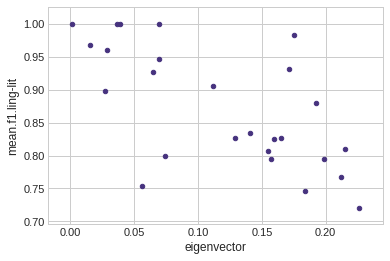

In [109]:
subgenres_nodes_df.plot.scatter("eigenvector","mean.f1.ling-lit",)

In [110]:
stats.pearsonr(
subgenres_nodes_df["eigenvector"],
subgenres_nodes_df["mean.f1.ling-lit"],
)


(-0.6543271915611995, 0.00028762290979139003)

Testing whether the eigenvector correlates with the canonization of the texts:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


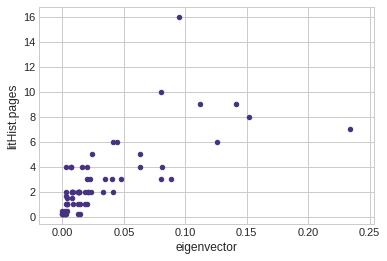

In [111]:
new_metadata_df.loc[new_metadata_df["in_network"]==1].plot.scatter("eigenvector","litHist.pages")

In [112]:
stats.pearsonr(
new_metadata_df.loc[new_metadata_df["in_network"]==1]["eigenvector"],
new_metadata_df.loc[new_metadata_df["in_network"]==1]["litHist.pages"],
)

(0.7192169197349049, 7.1022787093341285e-12)

## Evaluate Model

Creating a single model:

In [235]:
amounts_of_features_per_subgenre = [20]
amounts_of_texts_per_subgenre = [5]
amounts_of_features_per_text = [5]

stds_deviation_of_feature_in_subgenre = [0.5]
stds_deviation_of_feature_in_text = [4]


nodes_df, edges_df, results_df, graph_gp, colors_list, sizes_list, weights_list, labels_list = genre_as_graph.make_complete_graph(bool_new_metadata_df, new_metadata_df, semantic_subgenres_lt,
                       selected_features_annotation_df, metadata_features_df,
                       results_features_zscores_df,
                       amounts_of_features_per_subgenre, amounts_of_texts_per_subgenre, amounts_of_features_per_text,
                       stds_deviation_of_feature_in_subgenre, stds_deviation_of_feature_in_text,
                       zscores_selected_features_df, texts_split, wdir, texts_without_genre_lt,)


(1428, 5)
(441, 5)
20 5 5 0.5 4 -0.65 0.0 0.72 0.0


In [236]:
subgenres_nodes_df

node       size      type              label  \
autobiografía          autobiografía  15.253763  subgenre      autobiografía   
aventura                    aventura  13.461649  subgenre           aventura   
biografía                  biografía  11.526165  subgenre          biografía   
bucólica                    bucólica  18.981362  subgenre           bucólica   
costumbrista            costumbrista  12.816487  subgenre       costumbrista   
diálogo                      diálogo  20.200000  subgenre            diálogo   
educación                  educación   5.432975  subgenre          educación   
episodio nacional  episodio nacional  17.834409  subgenre  episodio nacional   
erótica                      erótica  17.332616  subgenre            erótica   
espiritual                espiritual   2.565591  subgenre         espiritual   
fantástico                fantástico  16.400717  subgenre         fantástico   
ficción-literaria  ficción-literaria   1.992115  subgenre  ficción-literaria   
filosófica                filosófica   3.497491  subgenre         filosófica   
greguería                  greguería  20.200000  subgenre          greguería   
guerra                        guerra  14.967025  subgenre             guerra   
histórica                  histórica   8.300358  subgenre          histórica   
humor                          humor   7.726882  subgenre              humor   
memorias                    memorias   7.798566  subgenre           memorias   
modernista                modernista   5.432975  subgenre         modernista   
mono-diálogo            mono-diálogo  20.200000  subgenre       mono-diálogo   
naturalista              naturalista   7.655197  subgenre        naturalista   
nivola                        nivola  20.200000  subgenre             nivola   
poética                      poética   5.863082  subgenre            poética   
psicológica              psicológica   6.364875  subgenre        psicológica   
realista                    realista   6.579928  subgenre           realista   
social                        social   0.200000  subgenre             social   

                   mean.f1.ling-lit  litHist.pages  number.authors  \
autobiografía                 0.931       1.284615              12   
aventura                      0.906       0.965306              15   
biografía                     0.879       1.436667              14   
bucólica                      0.983       1.102299              39   
costumbrista                  0.897       1.056250               4   
diálogo                       1.000       0.950000               8   
educación                     0.794       1.661429              24   
episodio nacional             0.967       0.227273               2   
erótica                       0.960       0.488235               9   
espiritual                    0.754       1.358824              15   
fantástico                    0.947       0.916667              14   
ficción-literaria             0.746       1.641053              33   
filosófica                    0.767       1.345455              33   
greguería                     1.000       0.200000               1   
guerra                        0.927       0.771429              12   
histórica                     0.834       1.459292              29   
humor                         0.826       1.004082              23   
memorias                      0.827       1.170909              21   
modernista                    0.794       1.611429              16   
mono-diálogo                  1.000       1.054545               7   
naturalista                   0.825       2.239759              22   
nivola                        1.000       4.800000               1   
poética                       0.800       1.880000               5   
psicológica                   0.807       1.580000              11   
realista                      0.810       1.495928              48   
social                        0.721       1.565405 

In [237]:
nodes_df

node       size      type              label  \
autobiografía          autobiografía  15.253763  subgenre      autobiografía   
aventura                    aventura  13.461649  subgenre           aventura   
biografía                  biografía  11.526165  subgenre          biografía   
bucólica                    bucólica  18.981362  subgenre           bucólica   
costumbrista            costumbrista  12.816487  subgenre       costumbrista   
diálogo                      diálogo  20.200000  subgenre            diálogo   
educación                  educación   5.432975  subgenre          educación   
episodio nacional  episodio nacional  17.834409  subgenre  episodio nacional   
erótica                      erótica  17.332616  subgenre            erótica   
espiritual                espiritual   2.565591  subgenre         espiritual   
fantástico                fantástico  16.400717  subgenre         fantástico   
ficción-literaria  ficción-literaria   1.992115  subgenre  ficción-literaria   
filosófica                filosófica   3.497491  subgenre         filosófica   
greguería                  greguería  20.200000  subgenre          greguería   
guerra                        guerra  14.967025  subgenre             guerra   
histórica                  histórica   8.300358  subgenre          histórica   
humor                          humor   7.726882  subgenre              humor   
memorias                    memorias   7.798566  subgenre           memorias   
modernista                modernista   5.432975  subgenre         modernista   
mono-diálogo            mono-diálogo  20.200000  subgenre       mono-diálogo   
naturalista              naturalista   7.655197  subgenre        naturalista   
nivola                        nivola  20.200000  subgenre             nivola   
poética                      poética   5.863082  subgenre            poética   
psicológica              psicológica   6.364875  subgenre        psicológica   
realista                    realista   6.579928  subgenre           realista   
social                        social   0.200000  subgenre             social   

                   mean.f1.ling-lit  litHist.pages  number.authors  \
autobiografía                 0.931       1.284615              12   
aventura                      0.906       0.965306              15   
biografía                     0.879       1.436667              14   
bucólica                      0.983       1.102299              39   
costumbrista                  0.897       1.056250               4   
diálogo                       1.000       0.950000               8   
educación                     0.794       1.661429              24   
episodio nacional             0.967       0.227273               2   
erótica                       0.960       0.488235               9   
espiritual                    0.754       1.358824              15   
fantástico                    0.947       0.916667              14   
ficción-literaria             0.746       1.641053              33   
filosófica                    0.767       1.345455              33   
greguería                     1.000       0.200000               1   
guerra                        0.927       0.771429              12   
histórica                     0.834       1.459292              29   
humor                         0.826       1.004082              23   
memorias                      0.827       1.170909              21   
modernista                    0.794       1.611429              16   
mono-diálogo                  1.000       1.054545               7   
naturalista                   0.825       2.239759              22   
nivola                        1.000       4.800000               1   
poética                       0.800       1.880000               5   
psicológica                   0.807       1.580000              11   
realista                      0.810       1.495928              48   
social                        0.721       1.565405 

Evaluating the model with many different values of the parameters:

In [ ]:
amounts_of_features_per_subgenre = [5,10,20,30,50]
amounts_of_texts_per_subgenre = [1,2,3,4,5,10,20]
amounts_of_features_per_text = [0,1,2,3,4,5,10,20]

stds_deviation_of_feature_in_subgenre = [0,0.5,1,1.5,2,2.5,3,4]
stds_deviation_of_feature_in_text = [0,0.5,1,1.5,2,2.5,3,4]



nodes_df, edges_df, results_df, graph_gp, colors_list, sizes_list, weights_list, labels_list = genre_as_graph.make_complete_graph(bool_new_metadata_df, new_metadata_df, semantic_subgenres_lt,
                       selected_features_annotation_df, metadata_features_df,
                       results_features_zscores_df,
                       amounts_of_features_per_subgenre, amounts_of_texts_per_subgenre, amounts_of_features_per_text,
                       stds_deviation_of_feature_in_subgenre, stds_deviation_of_feature_in_text,
                       zscores_selected_features_df, texts_split, wdir, texts_without_genre_lt,)

results_df

In [ ]:
results_df.to_csv(wdir+"results_evaluation_model.csv",sep="\t")

In [ ]:
results_df.sort_values(by="r-eigenvector-mean.f1.ling-lit").plot.line(x ="r-eigenvector-mean.f1.ling-lit", y = ["amount_of_texts_per_subgenre","amount_of_features_per_text","amount_of_features_per_subgenre"])

In [ ]:
results_df.sort_values(by="r-eigenvector-mean.f1.ling-lit").plot.scatter(x ="r-eigenvector-mean.f1.ling-lit", y = "amount_of_features_per_text")

In [126]:
results_df.head()

r-eigenvector-mean.f1.ling-lit  pvalue-eigenvector-mean.f1.ling-lit  \
0                       -0.471562                             0.015018   
1                       -0.471562                             0.015018   
2                       -0.471562                             0.015018   
3                       -0.471562                             0.015018   
4                        0.180696                             0.377041   

   r-eigenvector-litHist.pages  pvalue-eigenvector-litHist.pages  \
0                     0.684017                          0.003476   
1                     0.684017                          0.003476   
2                     0.684017                          0.003476   
3                     0.684017                          0.003476   
4                     0.104018                          0.701451   

   amount_of_features_per_subgenre  amount_of_texts_per_subgenre  \
0                                5                             1   
1                                5                             1   
2                                5                             1   
3                                5                             1   
4                                5                             1   

   amount_of_features_per_text  std_deviation_of_feature_in_subgenre  \
0                            0                                   0.0   
1                            0                                   0.0   
2                            0                                   0.5   
3                            0                                   0.5   
4                            1                                   0.0   

   std_deviation_of_feature_in_text  mean-r  
0                               0.0    0.58  
1                               0.5    0.58  
2                               0.0    0.58  
3                               0.5    0.58  
4                               0.0    0.14

In [3]:
# Por corregir, realizar de nuevo evaluación de esto:

In [121]:
results_df["mean-r"] = results_df[["r-eigenvector-mean.f1.ling-lit","r-eigenvector-litHist.pages"]].abs().mean(axis=1).round(2)

In [122]:
results_df.sort_values(by="mean-r",inplace=True,ascending=False)

In [123]:
results_df

r-eigenvector-mean.f1.ling-lit  pvalue-eigenvector-mean.f1.ling-lit  \
0                        -0.65443                             0.000287   

   r-eigenvector-litHist.pages  pvalue-eigenvector-litHist.pages  \
0                     0.717065                      8.764277e-12   

   amount_of_features_per_subgenre  amount_of_texts_per_subgenre  \
0                               20                             5   

   amount_of_features_per_text  std_deviation_of_feature_in_subgenre  \
0                            5                                   0.5   

   std_deviation_of_feature_in_text  mean-r  
0                                 4    0.69

In [124]:
results_df.loc[(results_df["pvalue-eigenvector-mean.f1.ling-lit"] < 0.05) & (results_df["pvalue-eigenvector-litHist.pages"] < 0.05) & (results_df["amount_of_features_per_text"] > 0) & (results_df["amount_of_features_per_subgenre"] > 0) & (results_df["amount_of_texts_per_subgenre"] > 0) & (results_df["amount_of_features_per_subgenre"] == 20) & (results_df["amount_of_texts_per_subgenre"] < 10) ].sort_values(by="mean-r",ascending=False)

r-eigenvector-mean.f1.ling-lit  pvalue-eigenvector-mean.f1.ling-lit  \
0                        -0.65443                             0.000287   

   r-eigenvector-litHist.pages  pvalue-eigenvector-litHist.pages  \
0                     0.717065                      8.764277e-12   

   amount_of_features_per_subgenre  amount_of_texts_per_subgenre  \
0                               20                             5   

   amount_of_features_per_text  std_deviation_of_feature_in_subgenre  \
0                            5                                   0.5   

   std_deviation_of_feature_in_text  mean-r  
0                                 4    0.69

In [7]:
results_df = pd.read_csv(wdir+"results_evaluation_model.csv",sep="\t", index_col=0)

In [8]:
results_df

r-eigenvector-mean.f1.ling-lit  pvalue-eigenvector-mean.f1.ling-lit  \
0                        -0.65443                             0.000287   

   r-eigenvector-litHist.pages  pvalue-eigenvector-litHist.pages  \
0                     0.717065                      8.764277e-12   

   amount_of_features_per_subgenre  amount_of_texts_per_subgenre  \
0                               20                             5   

   amount_of_features_per_text  std_deviation_of_feature_in_subgenre  \
0                            5                                   0.5   

   std_deviation_of_feature_in_text  mean-r  
0                                 4    0.69

## Observing texts without subgenre

In [238]:
new_metadata_df.loc[texts_without_genre_lt]

idno author.name       title  year supergenre   genre  \
ne0358  ne0358       Serna  MujerAmbar  1927  narrative  novela   
ne0355  ne0355       Serna      Chalet  1923  narrative  novela   
ne0120  ne0120    RdCastro        Loco  1881  narrative  novela   

       subgenre.cligs.important author.country  author.viaf author.bne  ...    \
ne0358              sentimental          Spain   68929740.0   XX927011  ...     
ne0355              sentimental          Spain   68929740.0   XX927011  ...     
ne0120              sentimental          Spain   51711491.0   XX881851  ...     

       realista social bucólica mono-diálogo ficción-literaria  \
ne0358      0.0    0.0      0.0          0.0               0.0   
ne0355      0.0    0.0      0.0          0.0               0.0   
ne0120      0.0    0.0      0.0          0.0               0.0   

       mean.prop.subgenres in_network   eigenvector betweenness degree  
ne0358                 0.0          1  1.365618e-18         0.0      0  
ne0355                 0.0          1  2.792523e-19         0.0      0  
ne0120                 0.0          1 -2.138078e-18         0.0      0  

[3 rows x 209 columns]

In [239]:
texts_without_genre_lt

['ne0358', 'ne0355', 'ne0120']

In [240]:
new_metadata_df.loc[texts_without_genre_lt][["title.main","author.name"]]

title.main author.name
ne0358       La mujer de ámbar       Serna
ne0355  El chalet de las rosas       Serna
ne0120          El primer loco    RdCastro

In [241]:
list(graph_gp.neighbors("ne0358"))

['setting.country_Italy']

In [242]:
list(graph_gp.neighbors("ne0355"))

['setting.country_France']

In [243]:
list(graph_gp.neighbors("ne0120"))

[]

In [244]:
print(genre_as_graph.neighborhood(graph_gp, "ne0358", 9))

['filosófica', 'histórica', 'end_?', 'lista@mariax', 'categoría@mariax', 'imitar@mariax', 'mecánica@mariax', 'protestar@mariax', 'exacto@mariax', 'imposible@mariax']


In [245]:
print(genre_as_graph.neighborhood(graph_gp, "ne0358", 9))


['filosófica', 'histórica', 'end_?', 'lista@mariax', 'categoría@mariax', 'imitar@mariax', 'mecánica@mariax', 'protestar@mariax', 'exacto@mariax', 'imposible@mariax']


In [246]:
genre_as_graph.neighborhood(graph_gp, "ne0355", 5)

['ficción-literaria']

In [247]:
genre_as_graph.neighborhood(graph_gp, "ne0120", 5)

[]

## Plotting Graph

Testing different manners of plotting the graph:

In [248]:
amounts_of_features_per_subgenre = [20]
amounts_of_texts_per_subgenre = [5]
amounts_of_features_per_text = [5]

stds_deviation_of_feature_in_subgenre = [0.5]
stds_deviation_of_feature_in_text = [4]


nodes_df, edges_df, results_df, graph_gp, colors_list, sizes_list, weights_list, labels_list = genre_as_graph.make_complete_graph(bool_new_metadata_df, new_metadata_df, semantic_subgenres_lt,
                       selected_features_annotation_df, metadata_features_df,
                       results_features_zscores_df,
                       amounts_of_features_per_subgenre, amounts_of_texts_per_subgenre, amounts_of_features_per_text,
                       stds_deviation_of_feature_in_subgenre, stds_deviation_of_feature_in_text,
                       zscores_selected_features_df, texts_split, wdir, texts_without_genre_lt,)


(1428, 5)
(441, 5)
20 5 5 0.5 4 -0.65 0.0 0.72 0.0


In [249]:
results_df

r-eigenvector-mean.f1.ling-lit  pvalue-eigenvector-mean.f1.ling-lit  \
0                        -0.65443                             0.000287   

   r-eigenvector-litHist.pages  pvalue-eigenvector-litHist.pages  \
0                     0.717065                      8.764277e-12   

   amount_of_features_per_subgenre  amount_of_texts_per_subgenre  \
0                               20                             5   

   amount_of_features_per_text  std_deviation_of_feature_in_subgenre  \
0                            5                                   0.5   

   std_deviation_of_feature_in_text  mean-r  
0                                 4    0.69

In [250]:
nodes_df

node       size      type              label  \
autobiografía          autobiografía  15.253763  subgenre      autobiografía   
aventura                    aventura  13.461649  subgenre           aventura   
biografía                  biografía  11.526165  subgenre          biografía   
bucólica                    bucólica  18.981362  subgenre           bucólica   
costumbrista            costumbrista  12.816487  subgenre       costumbrista   
diálogo                      diálogo  20.200000  subgenre            diálogo   
educación                  educación   5.432975  subgenre          educación   
episodio nacional  episodio nacional  17.834409  subgenre  episodio nacional   
erótica                      erótica  17.332616  subgenre            erótica   
espiritual                espiritual   2.565591  subgenre         espiritual   
fantástico                fantástico  16.400717  subgenre         fantástico   
ficción-literaria  ficción-literaria   1.992115  subgenre  ficción-literaria   
filosófica                filosófica   3.497491  subgenre         filosófica   
greguería                  greguería  20.200000  subgenre          greguería   
guerra                        guerra  14.967025  subgenre             guerra   
histórica                  histórica   8.300358  subgenre          histórica   
humor                          humor   7.726882  subgenre              humor   
memorias                    memorias   7.798566  subgenre           memorias   
modernista                modernista   5.432975  subgenre         modernista   
mono-diálogo            mono-diálogo  20.200000  subgenre       mono-diálogo   
naturalista              naturalista   7.655197  subgenre        naturalista   
nivola                        nivola  20.200000  subgenre             nivola   
poética                      poética   5.863082  subgenre            poética   
psicológica              psicológica   6.364875  subgenre        psicológica   
realista                    realista   6.579928  subgenre           realista   
social                        social   0.200000  subgenre             social   

                   mean.f1.ling-lit  litHist.pages  number.authors  \
autobiografía                 0.931       1.284615              12   
aventura                      0.906       0.965306              15   
biografía                     0.879       1.436667              14   
bucólica                      0.983       1.102299              39   
costumbrista                  0.897       1.056250               4   
diálogo                       1.000       0.950000               8   
educación                     0.794       1.661429              24   
episodio nacional             0.967       0.227273               2   
erótica                       0.960       0.488235               9   
espiritual                    0.754       1.358824              15   
fantástico                    0.947       0.916667              14   
ficción-literaria             0.746       1.641053              33   
filosófica                    0.767       1.345455              33   
greguería                     1.000       0.200000               1   
guerra                        0.927       0.771429              12   
histórica                     0.834       1.459292              29   
humor                         0.826       1.004082              23   
memorias                      0.827       1.170909              21   
modernista                    0.794       1.611429              16   
mono-diálogo                  1.000       1.054545               7   
naturalista                   0.825       2.239759              22   
nivola                        1.000       4.800000               1   
poética                       0.800       1.880000               5   
psicológica                   0.807       1.580000              11   
realista                      0.810       1.495928              48   
social                        0.721       1.565405 

In [251]:
len(graph_gp.nodes)

441

In [252]:
len(graph_gp.edges)

697

In [253]:
labels_list

{'1@person': '1@person',
 'abandonar@mariax': 'abandonar ',
 'abatir@mariax': 'abatir ',
 'abusar@mariax': 'abusar ',
 'ademán@mariax': 'ademán ',
 'adivinar@mariax': 'adivinar ',
 'adjetivo@mariax': 'adjetivo ',
 'admirar@mariax': 'admirar ',
 'afectación@mariax': 'afectación ',
 'afeminado@mariax': 'afeminado ',
 'ahorrar@mariax': 'ahorrar ',
 'ajetrear@mariax': 'ajetrear ',
 'alojar@mariax': 'alojar ',
 'altar@mariax': 'altar ',
 'am.chapters': 'am.chapters',
 'am.divisions': 'am.divisions',
 'am.divs': 'am.divs',
 'am.parts': 'am.parts',
 'am.sections': 'am.sections',
 'am.sps': 'am.sps',
 'am.ss': 'am.ss',
 'am.verses': 'am.verses',
 'anular@mariax': 'anular ',
 'aparecer@mariax': 'aparecer ',
 'apartar@mariax': 'apartar ',
 'apasionar@mariax': 'apasionar ',
 'apetecer@mariax': 'apetecer ',
 'aprender@mariax': 'aprender ',
 'apresar@mariax': 'apresar ',
 'arrendar@mariax': 'arrendar ',
 'arrepentirse@mariax': 'arrepentirse ',
 'arriesgar@mariax': 'arriesgar ',
 'arte@mariax': 'art

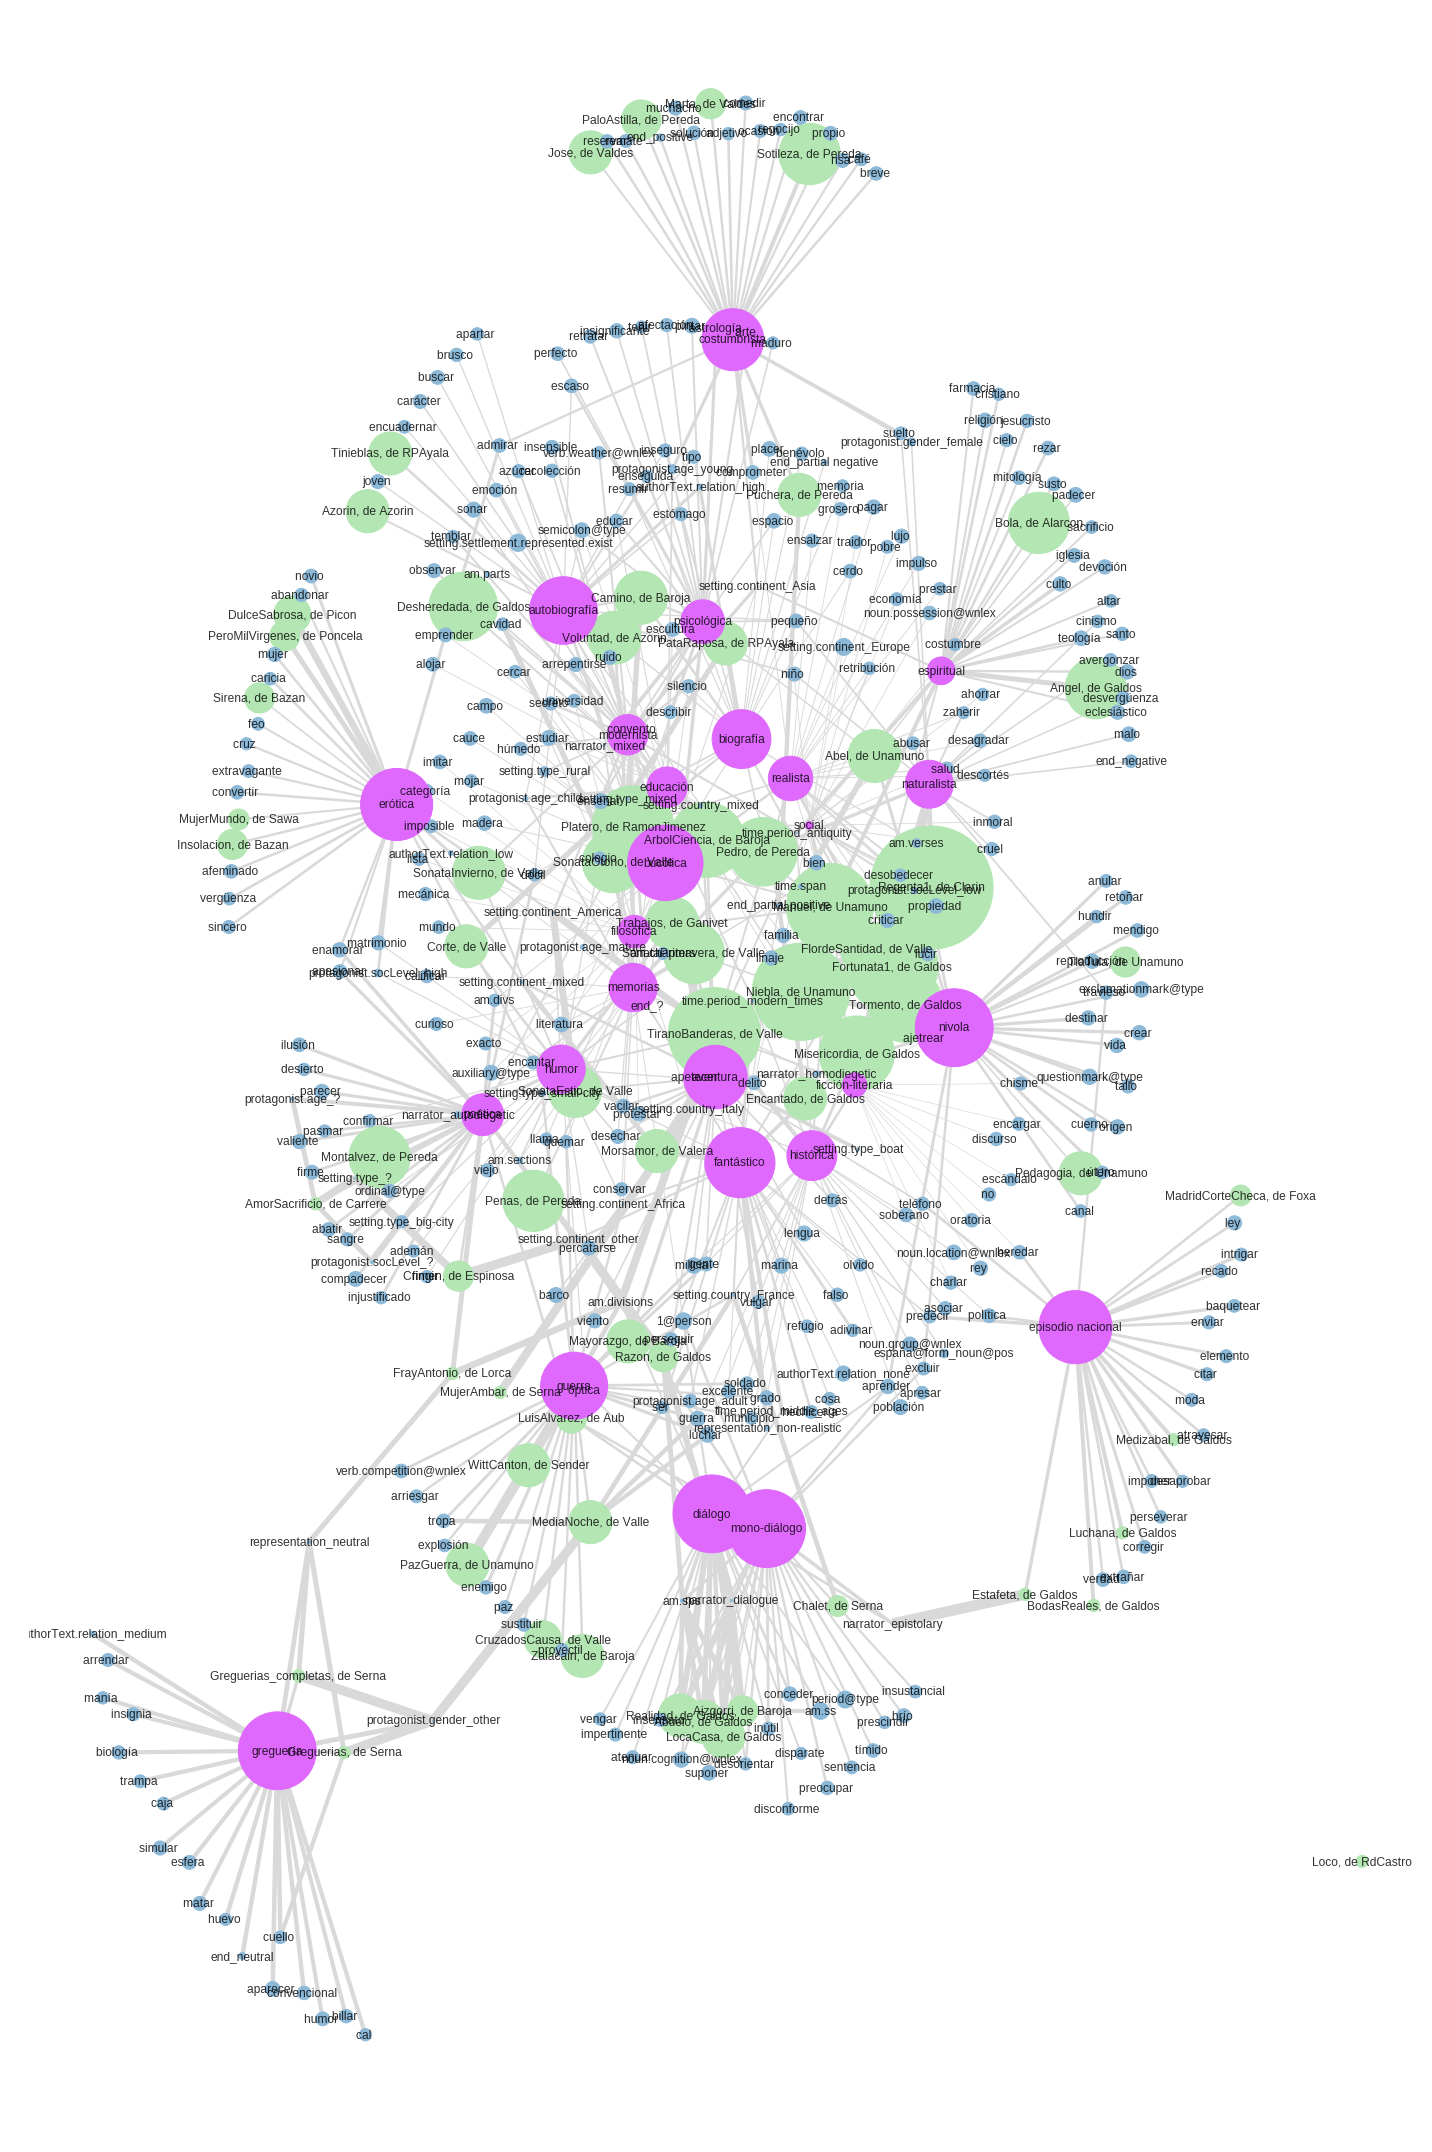

In [254]:
genre_as_graph.plot_graph(graph_gp, labels_list, weights_list, colors_list, sizes_list, wdir, savefig = False)

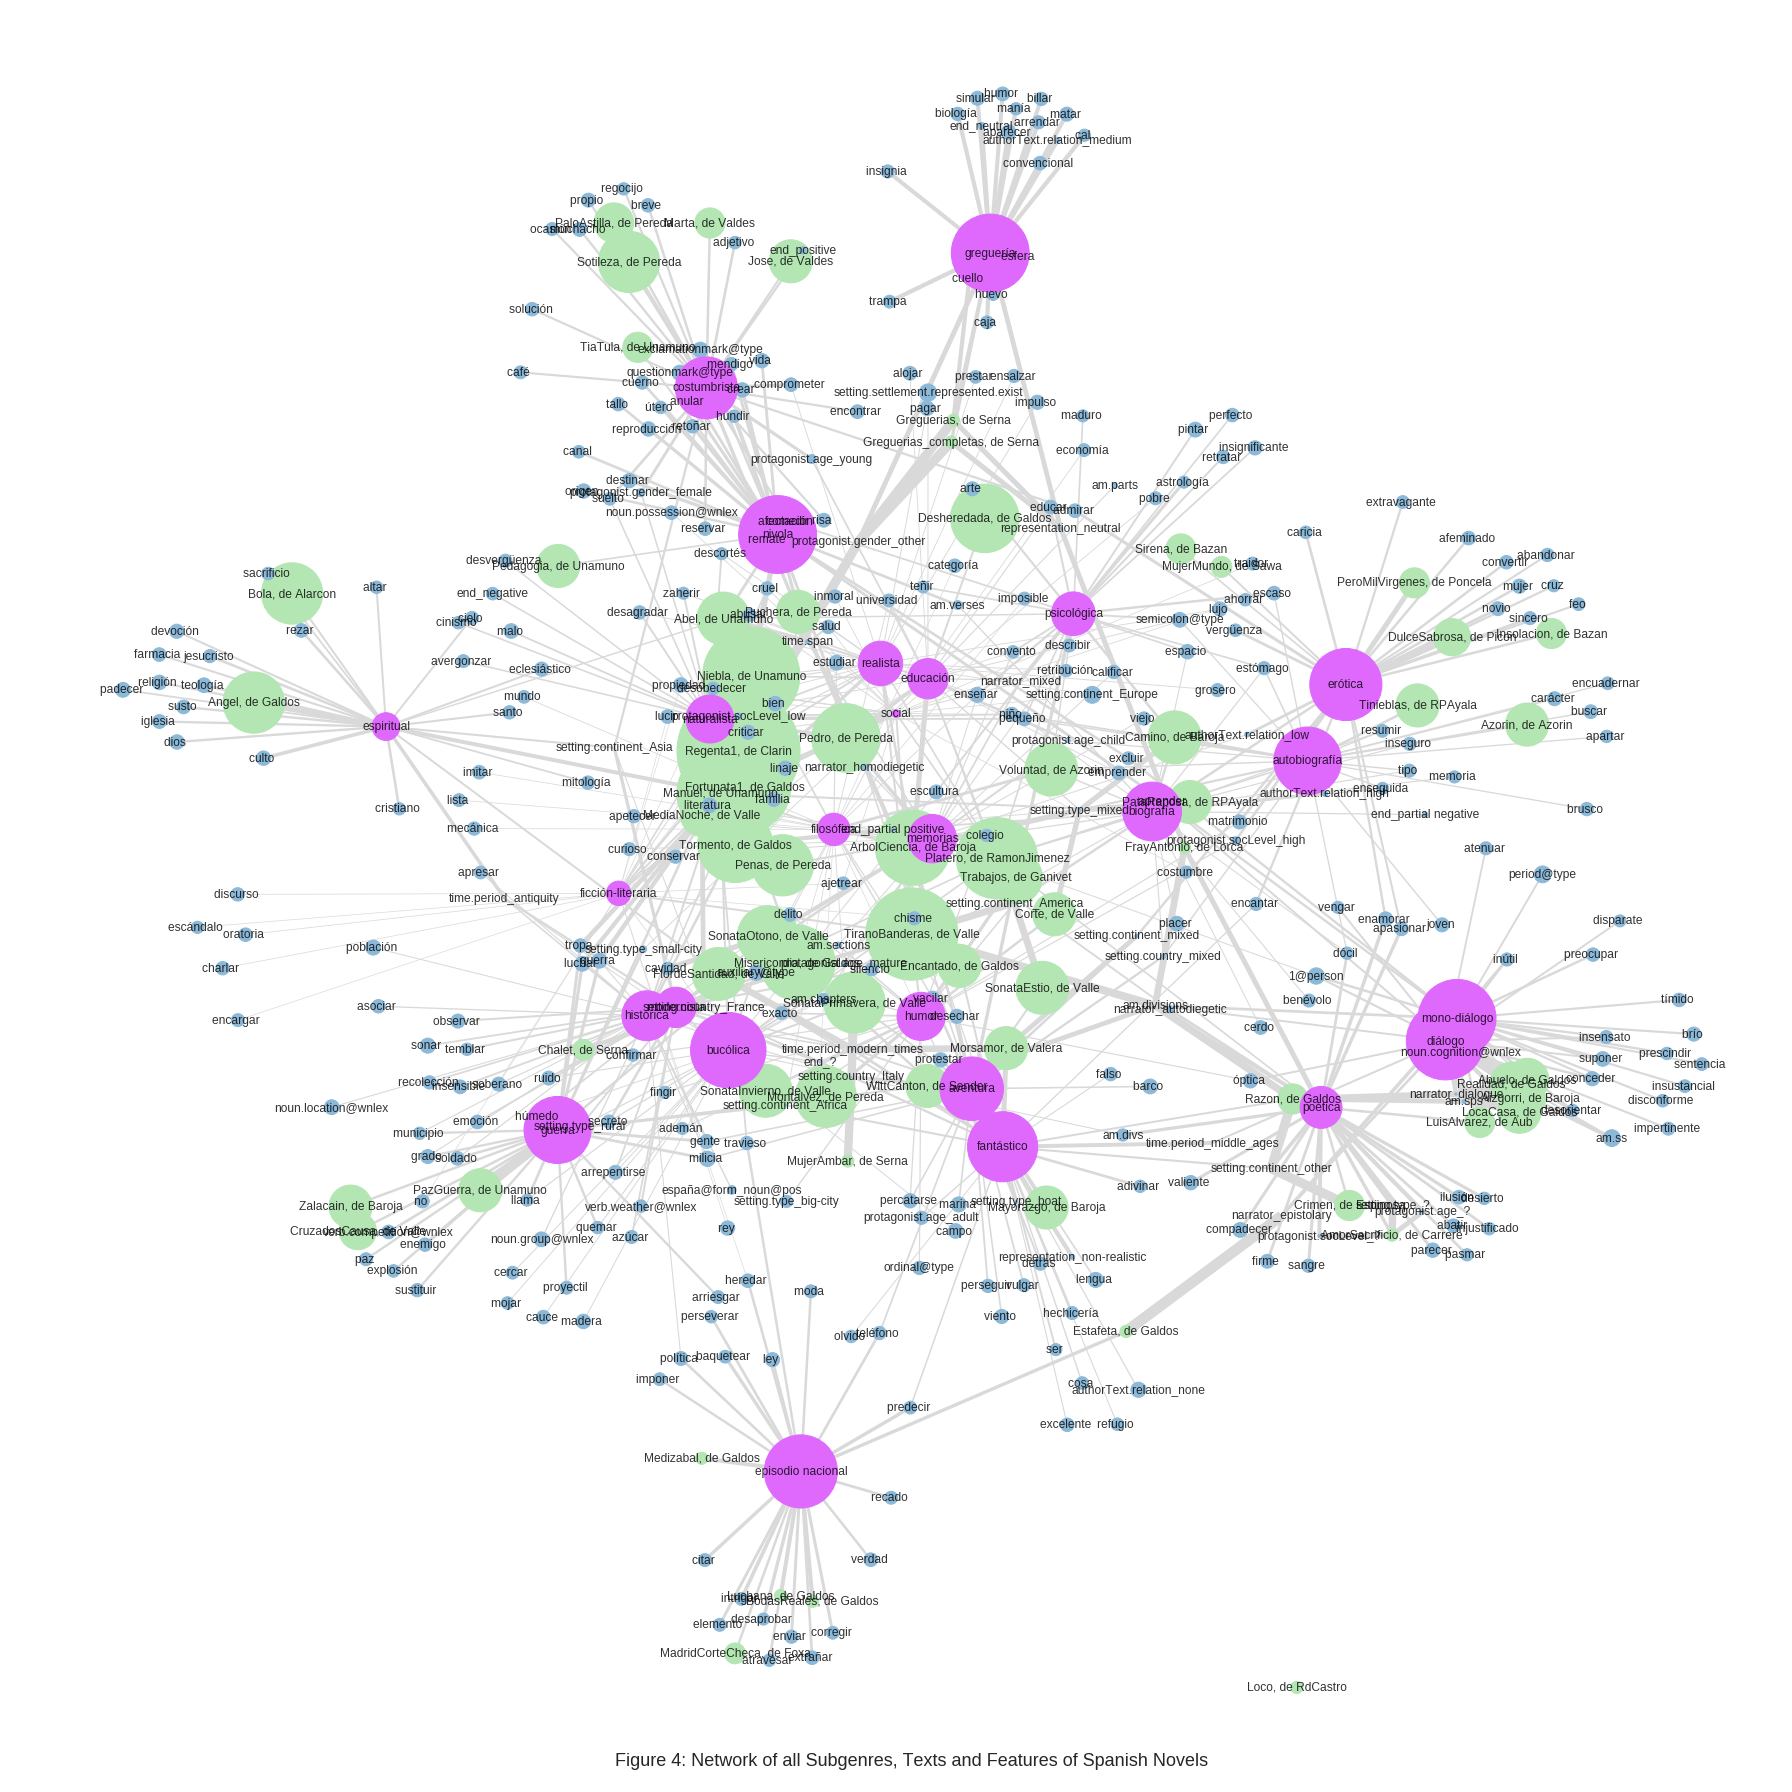

In [256]:
genre_as_graph.plot_graph(graph_gp, labels_list, weights_list, colors_list, sizes_list, wdir, figsize=(25,25), pos_str = "spring", k = 3, iterations = 1000, title = "Figure 4: Network of all Subgenres, Texts and Features of Spanish Novels", savefig = True)

Looking at the eigenvector of each subgenre:

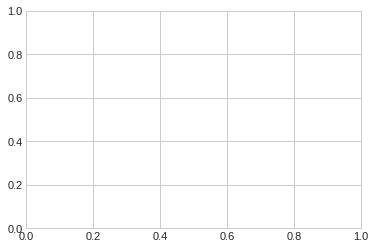

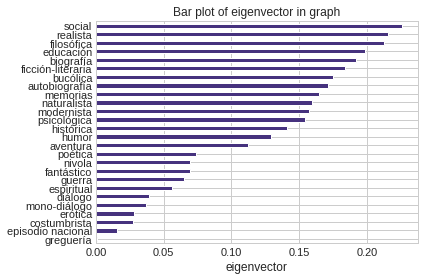

In [138]:
describe_data.simple_bars(nodes_df.sort_values(by="eigenvector")[["eigenvector"]].T,"eigenvector",wdir,"graph")


## Plotting Sections of the Graph

Looking at different sections of the graph. First, I create a model:

In [210]:
amounts_of_features_per_subgenre = [25]
amounts_of_texts_per_subgenre = [20]
amounts_of_features_per_text = [20]

stds_deviation_of_feature_in_subgenre = [0]
stds_deviation_of_feature_in_text = [1.5]


modified_subgenres_nodes_df, edges_df, results_df, graph_gp, colors_list, sizes_list, weights_list, labels_list = genre_as_graph.make_complete_graph(bool_new_metadata_df, new_metadata_df, semantic_subgenres_lt,
                       selected_features_annotation_df, metadata_features_df,
                       results_features_zscores_df,
                       amounts_of_features_per_subgenre, amounts_of_texts_per_subgenre, amounts_of_features_per_text,
                       stds_deviation_of_feature_in_subgenre, stds_deviation_of_feature_in_text,
                       zscores_selected_features_df, texts_split, wdir, texts_without_genre_lt,)


(1428, 5)
(629, 5)
25 20 20 0 1.5 -0.29 0.15 0.13 0.08


Now three novels and their features are observed:

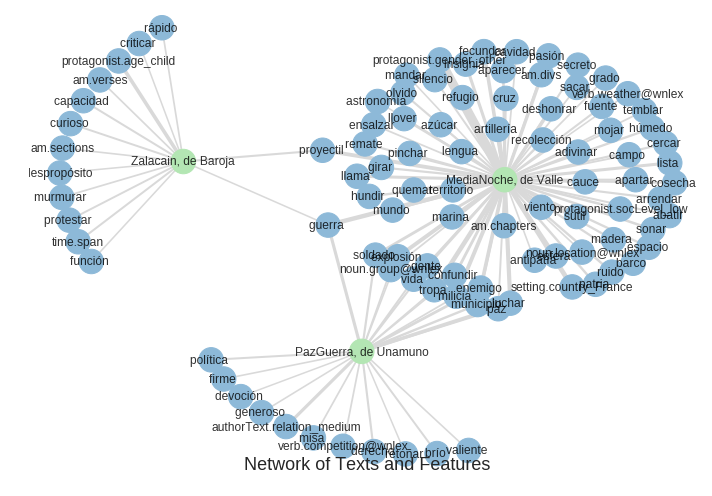

In [211]:
graph_section_gp = graph_gp.copy()
for node in list(graph_section_gp.nodes()):
    if (node not in list(graph_section_gp.neighbors("ne0066"))) and (node not in list(graph_section_gp.neighbors("ne0037")))  and (node not in list(graph_section_gp.neighbors("ne0114"))) and (node not in ["ne0066","ne0037","ne0114"]):
        graph_section_gp.remove_node(node)
 
for node in list(graph_section_gp.nodes()):
    if graph_section_gp.nodes[node]["bipartite"] == 0:
        graph_section_gp.remove_node(node)



for node in nodes_df["node"]:
    if (node not in edges_df["source"].tolist() and node not in edges_df["target"].tolist() and node not in texts_without_genre_lt) or (node in texts_split):
        nodes_df = nodes_df.loc[nodes_df["node"] != node]        


color_dict = {0:'#df68fd',1:'#8db9d8', 2:"#b3e6b3"}
color_list = [color_dict[i[1]] for i in graph_section_gp.nodes.data('bipartite')]
sizes = [[600] for n in graph_section_gp.nodes()]
widths = [w['weight'] for (u, v, w) in graph_section_gp.edges(data=True)]
labels_list = {}
for key, values in dict(graph_section_gp.nodes(data=True)).items():
    labels_list[key] = values["label"]
    
pos = nx.nx_agraph.graphviz_layout(graph_section_gp, prog="neato")
#pos = nx.spring_layout(graph_gp, k = 1.1, iterations=)#, , iterations = 1500)
plt.figure(figsize=(10,7))
plt.axis('off')
nx.draw_networkx_labels(graph_section_gp, pos, labels_list, font_color = 'black', alpha = 0.8)
nx.draw_networkx_edges(graph_section_gp, pos, edge_color = "#d9d9d9",width = widths)
nx.draw_networkx_nodes(graph_section_gp, pos, node_size = sizes, node_color = color_list, alpha=1)
plt.title("Network of Texts and Features", y = 0, fontdict = { "fontsize" : 18})
plt.tight_layout()
plt.savefig(wdir+"/visualisations/graph_3_texts_features.png",dpi=300, format="png")

plt.show()

In [212]:
amounts_of_features_per_subgenre = [25]
amounts_of_texts_per_subgenre = [25]
amounts_of_features_per_text = [20]

stds_deviation_of_feature_in_subgenre = [0]
stds_deviation_of_feature_in_text = [1.5]


modified_subgenres_nodes_df, edges_df, results_df, graph_gp, colors_list, sizes_list, weights_list, labels_list = genre_as_graph.make_complete_graph(bool_new_metadata_df, new_metadata_df, semantic_subgenres_lt,
                       selected_features_annotation_df, metadata_features_df,
                       results_features_zscores_df,
                       amounts_of_features_per_subgenre, amounts_of_texts_per_subgenre, amounts_of_features_per_text,
                       stds_deviation_of_feature_in_subgenre, stds_deviation_of_feature_in_text,
                       zscores_selected_features_df, texts_split, wdir, texts_without_genre_lt,)


(1428, 5)
(654, 5)
25 25 20 0 1.5 -0.33 0.1 0.1 0.14


Now the same three novels and their labels:

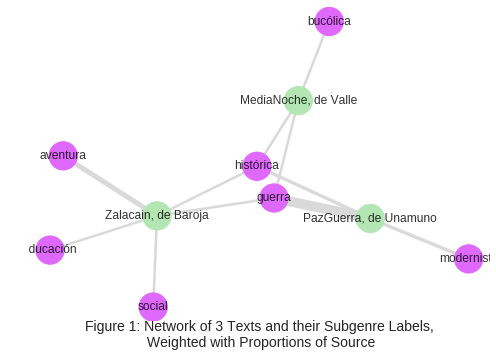

In [213]:
graph_section_gp = graph_gp.copy()
for node in list(graph_section_gp.nodes()):
    if (node not in list(graph_section_gp.neighbors("ne0066"))) and (node not in list(graph_section_gp.neighbors("ne0037")))  and (node not in list(graph_section_gp.neighbors("ne0114"))) and (node not in ["ne0066","ne0037","ne0114"]):
        graph_section_gp.remove_node(node)

for node in list(graph_section_gp.nodes()):
    if graph_section_gp.nodes[node]["bipartite"] == 1:
        graph_section_gp.remove_node(node)



for node in nodes_df["node"]:
    if (node not in edges_df["source"].tolist() and node not in edges_df["target"].tolist() and node not in texts_without_genre_lt) or (node in texts_split):
        nodes_df = nodes_df.loc[nodes_df["node"] != node]        


color_dict = {0:'#df68fd',1:'#8db9d8', 2:"#b3e6b3"}
color_list = [color_dict[i[1]] for i in graph_section_gp.nodes.data('bipartite')]
sizes = [[800] for n in graph_section_gp.nodes()]
widths = [w['weight'] for (u, v, w) in graph_section_gp.edges(data=True)]
labels_list = {}
for key, values in dict(graph_section_gp.nodes(data=True)).items():
    labels_list[key] = values["label"]
    
pos = nx.nx_agraph.graphviz_layout(graph_section_gp, prog="neato")
plt.figure(figsize=(7,5))
plt.axis('off')
nx.draw_networkx_labels(graph_section_gp, pos, labels_list, font_color = 'black', alpha = 0.8)
nx.draw_networkx_edges(graph_section_gp, pos, edge_color = "#d9d9d9",width = widths)
nx.draw_networkx_nodes(graph_section_gp, pos, node_size=sizes, node_color=color_list)
plt.title("Figure 1: Network of 3 Texts and their Subgenre Labels,\n Weighted with Proportions of Source", y = -0.1, fontdict = { "fontsize" : 14})

plt.tight_layout()
plt.savefig(wdir+"/visualisations/graph_3_texts_genres.png",dpi=300, format="png")

plt.show()

In [214]:
edges_df.loc[(edges_df["target"].isin(["ne0066","ne0037","ne0114"])) & (edges_df["type"].isin(["subgenre-novel"]))].sort_values(by="weight")

source  target           target-label              title.main  \
129   educación  ne0066    Zalacain, de Baroja  Zalacaín el aventurero   
234      guerra  ne0037   MediaNoche, de Valle          La media noche   
235      guerra  ne0066    Zalacain, de Baroja  Zalacaín el aventurero   
275   histórica  ne0066    Zalacain, de Baroja  Zalacaín el aventurero   
277   histórica  ne0037   MediaNoche, de Valle          La media noche   
459      social  ne0066    Zalacain, de Baroja  Zalacaín el aventurero   
475    bucólica  ne0037   MediaNoche, de Valle          La media noche   
270   histórica  ne0114  PazGuerra, de Unamuno        Paz en la guerra   
342  modernista  ne0114  PazGuerra, de Unamuno        Paz en la guerra   
33     aventura  ne0066    Zalacain, de Baroja  Zalacaín el aventurero   
236      guerra  ne0114  PazGuerra, de Unamuno        Paz en la guerra   

               type     weight  
129  subgenre-novel   2.500000  
234  subgenre-novel   2.500000  
235  subgenre-novel   2.500000  
275  subgenre-novel   2.500000  
277  subgenre-novel   2.500000  
459  subgenre-novel   2.500000  
475  subgenre-novel   2.500000  
270  subgenre-novel   3.333333  
342  subgenre-novel   3.333333  
33   subgenre-novel   5.000000  
236  subgenre-novel  10.000000

In [215]:
edges_df

source                       target target-label  \
0                autobiografía     authorText.relation_high                
1                autobiografía           setting.type_mixed                
2                autobiografía                  niño@mariax                
3                autobiografía              carácter@mariax                
4                autobiografía              estómago@mariax                
5                autobiografía        setting.country_mixed                
6                autobiografía             enseguida@mariax                
7                autobiografía               resumir@mariax                
8                autobiografía                  tipo@mariax                
9                autobiografía                 joven@mariax                
10               autobiografía               pequeño@mariax                
11               autobiografía                buscar@mariax                
12               autobiografía                escaso@mariax                
13               autobiografía              inseguro@mariax                
14               autobiografía               apartar@mariax                
15               autobiografía                 dócil@mariax                
16               autobiografía                brusco@mariax                
17               autobiografía           encuadernar@mariax                
18               autobiografía        protagonist.age_child                
19               autobiografía               semicolon@type                
20               autobiografía  protagonist.socLevel_medium                
21               autobiografía               digerir@mariax                
22               autobiografía              benévolo@mariax                
23               autobiografía               colegio@mariax                
24               autobiografía                 sutil@mariax                
25                    aventura            setting.type_boat                
26                    aventura        setting.country_Italy                
27                    aventura      setting.continent_mixed                
28                    aventura               vacilar@mariax                
29                    aventura              desechar@mariax                
...                        ...                          ...          ...   
4499  setting.continent_Africa                       ne0271                
4500            setting.type_?                       ne0349                
4501            setting.type_?                       ne0380                
4502            narrator_mixed                       ne0084                
4503            narrator_mixed                       ne0111                
4504            narrator_mixed                       ne0150                
4505            narrator_mixed                       ne0151                
4506            narrator_mixed                       ne0303                
4507     setting.country_Italy                       ne0015                
4508     setting.country_Italy                       ne0241                
4509     setting.country_Italy                       ne0305                
4510     setting.country_Italy                       ne0358                
4511     time.period_antiquity                       ne0054                
4512     time.period_antiquity                       ne0055                
4513     time.period_antiquity                       ne0191                
4514  protagonist.gender_other                       ne0037                
4515  protagonist.gender_other                       ne0172                
4516  protagonist.gender_other                       ne0173                
4517   setting.continent_other                       ne0250                
4518   setting.continent_other                       ne0365                
4519   setting.continent_other                       ne0380             

Now the set of nodes stay, but the perspective is changed:

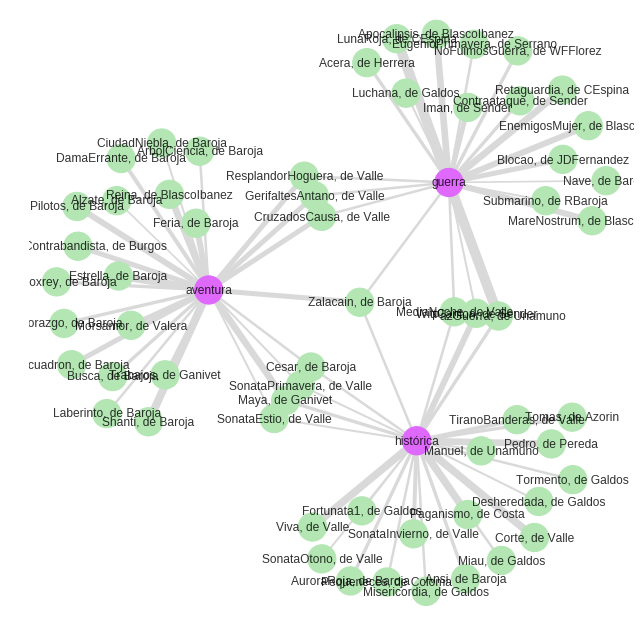

In [216]:
graph_section_gp = graph_gp.copy()
for node in list(graph_section_gp.nodes()):
    if (node not in list(graph_section_gp.neighbors("histórica"))) and (node not in list(graph_section_gp.neighbors("guerra"))) and (node not in list(graph_section_gp.neighbors("aventura"))) and (node not in ["histórica","guerra","aventura"]):
        graph_section_gp.remove_node(node)

    try:
        if graph_section_gp.nodes[node]["bipartite"] == 1:
            graph_section_gp.remove_node(node)
    except:
        pass



color_dict = {0:'#df68fd',1:'#8db9d8', 2:"#b3e6b3"}
color_list = [color_dict[i[1]] for i in graph_section_gp.nodes.data('bipartite')]
sizes = [[800] for n in graph_section_gp.nodes()]
widths = [w['weight'] for (u, v, w) in graph_section_gp.edges(data=True)]
labels_list = {}
for key, values in dict(graph_section_gp.nodes(data=True)).items():
    labels_list[key] = values["label"]
    
pos = nx.nx_agraph.graphviz_layout(graph_section_gp, prog="neato")
plt.figure(figsize=(9,9))
plt.axis('off')
nx.draw_networkx_labels(graph_section_gp, pos, labels_list, font_color = 'black', alpha = 0.8)
nx.draw_networkx_edges(graph_section_gp, pos, edge_color = "#d9d9d9",width = widths)
nx.draw_networkx_nodes(graph_section_gp, pos, node_size=sizes, node_color=color_list)
plt.tight_layout()
plt.savefig(wdir+"/visualisations/graph_3_genres_texts.png",dpi=300, format="png")

plt.show()

What are the distinctive feature of each subgenre?

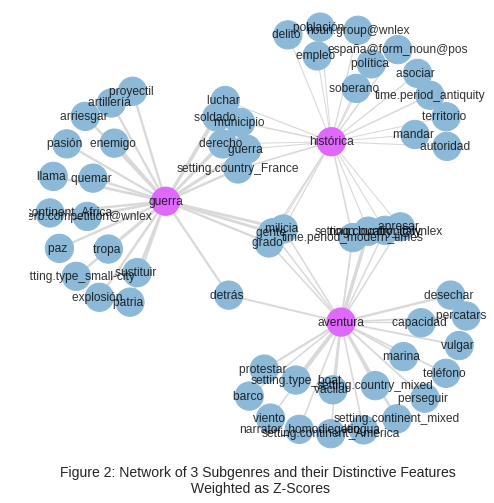

In [217]:
graph_section_gp = graph_gp.copy()
for node in list(graph_section_gp.nodes()):
    if (node not in list(graph_section_gp.neighbors("histórica"))) and (node not in list(graph_section_gp.neighbors("guerra"))) and (node not in list(graph_section_gp.neighbors("aventura"))) and (node not in ["histórica","guerra","aventura"]):
        graph_section_gp.remove_node(node)
    try:
        if graph_section_gp.nodes[node]["bipartite"] == 2:
            graph_section_gp.remove_node(node)
    except:
        pass


color_dict = {0:'#df68fd',1:'#8db9d8', 2:"#b3e6b3"}
color_list = [color_dict[i[1]] for i in graph_section_gp.nodes.data('bipartite')]
sizes = [[800] for n in graph_section_gp.nodes()]
widths = [w['weight'] for (u, v, w) in graph_section_gp.edges(data=True)]
labels_list = {}
for key, values in dict(graph_section_gp.nodes(data=True)).items():
    labels_list[key] = values["label"]

pos = nx.nx_agraph.graphviz_layout(graph_section_gp, prog="neato")
plt.figure(figsize=(7,7))
plt.axis('off')
nx.draw_networkx_labels(graph_section_gp, pos, labels_list, font_color = 'black', alpha = 0.8)
nx.draw_networkx_edges(graph_section_gp, pos, edge_color = "#d9d9d9",width = widths)
nx.draw_networkx_nodes(graph_section_gp, pos, node_size=sizes, node_color=color_list)
plt.title("Figure 2: Network of 3 Subgenres and their Distinctive Features\n Weighted as Z-Scores", y = -0.1, fontdict = { "fontsize" : 14})
plt.tight_layout()
plt.savefig(wdir+"/visualisations/graph_3_genres_features.png",dpi=300, format="png")

plt.show()

In [218]:
amounts_of_features_per_subgenre = [20]
amounts_of_texts_per_subgenre = [10]
amounts_of_features_per_text = [5]

stds_deviation_of_feature_in_subgenre = [0]
stds_deviation_of_feature_in_text = [1.5]


modified_subgenres_nodes_df, edges_df, results_df, graph_gp, colors_list, sizes_list, weights_list, labels_list = genre_as_graph.make_complete_graph(bool_new_metadata_df, new_metadata_df, semantic_subgenres_lt,
                       selected_features_annotation_df, metadata_features_df,
                       results_features_zscores_df,
                       amounts_of_features_per_subgenre, amounts_of_texts_per_subgenre, amounts_of_features_per_text,
                       stds_deviation_of_feature_in_subgenre, stds_deviation_of_feature_in_text,
                       zscores_selected_features_df, texts_split, wdir, texts_without_genre_lt,)


(1428, 5)
(486, 5)
20 10 5 0 1.5 -0.4 0.04 0.3 0.0


Now the three sets of nodes of the three subgenres are explored:

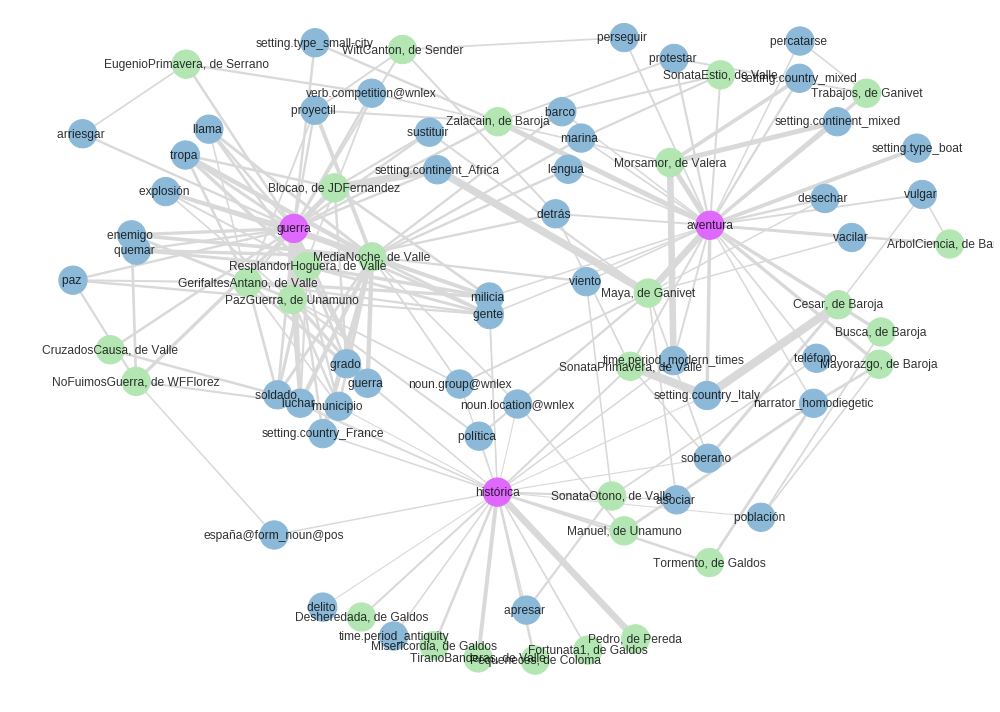

In [219]:
graph_section_gp = graph_gp.copy()
for node in list(graph_section_gp.nodes()):
    if (node not in list(graph_section_gp.neighbors("aventura"))) and (node not in list(graph_section_gp.neighbors("histórica"))) and (node not in list(graph_section_gp.neighbors("guerra"))) and (node not in ["aventura","histórica","guerra"]):
        graph_section_gp.remove_node(node)




color_dict = {0:'#df68fd',1:'#8db9d8', 2:"#b3e6b3"}
color_list = [color_dict[i[1]] for i in graph_section_gp.nodes.data('bipartite')]
sizes = [[800] for n in graph_section_gp.nodes()]
widths = [w['weight'] for (u, v, w) in graph_section_gp.edges(data=True)]
labels_list = {}
for key, values in dict(graph_section_gp.nodes(data=True)).items():
    labels_list[key] = values["label"]
    
pos = nx.nx_agraph.graphviz_layout(graph_section_gp, prog="neato")
plt.figure(figsize=(14,10))
plt.axis('off')
nx.draw_networkx_labels(graph_section_gp, pos, labels_list, font_color = 'black', alpha = 0.8)
nx.draw_networkx_edges(graph_section_gp, pos, edge_color = "#d9d9d9",width = widths)
nx.draw_networkx_nodes(graph_section_gp, pos, node_size=sizes, node_color=color_list)
plt.tight_layout()
plt.savefig(wdir+"/visualisations/graph_3_genres_features_labels.png",dpi=300, format="png")


plt.show()

The same, but also adding the greguerías:

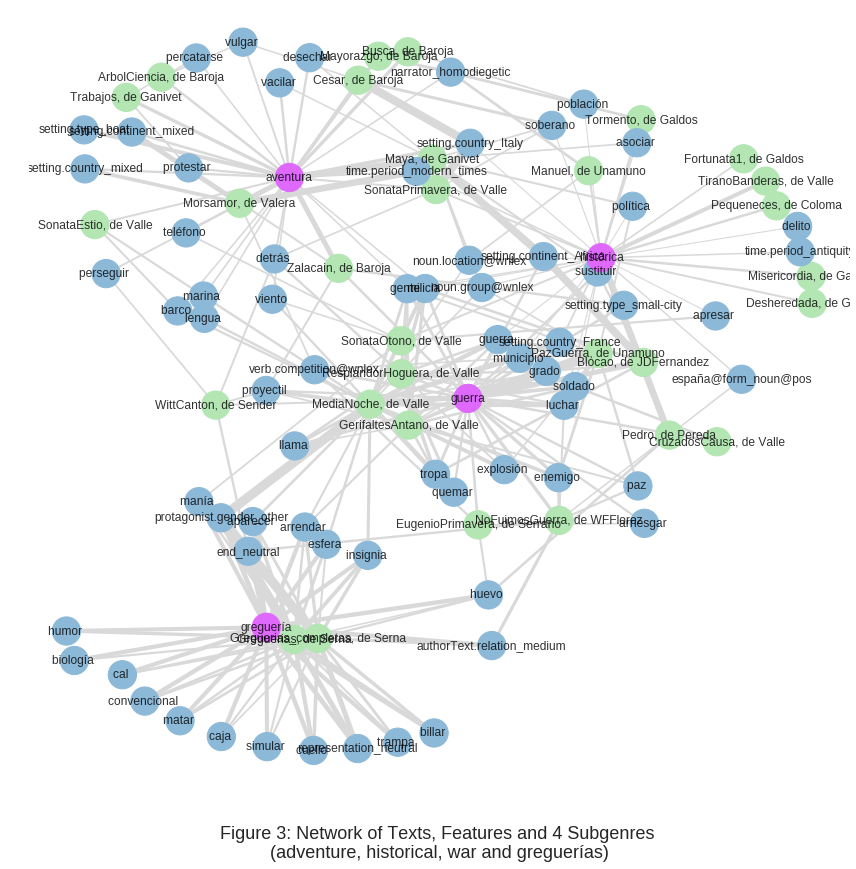

In [220]:
graph_section_gp = graph_gp.copy()
for node in list(graph_section_gp.nodes()):
    if (node not in list(graph_section_gp.neighbors("aventura"))) and (node not in list(graph_section_gp.neighbors("histórica"))) and (node not in list(graph_section_gp.neighbors("guerra"))) and (node not in list(graph_section_gp.neighbors("greguería")))  and (node not in ["aventura","histórica","guerra","greguería"]):
        graph_section_gp.remove_node(node)




color_dict = {0:'#df68fd',1:'#8db9d8', 2:"#b3e6b3"}
color_list = [color_dict[i[1]] for i in graph_section_gp.nodes.data('bipartite')]
sizes = [[800] for n in graph_section_gp.nodes()]
widths = [w['weight'] for (u, v, w) in graph_section_gp.edges(data=True)]
labels_list = {}
for key, values in dict(graph_section_gp.nodes(data=True)).items():
    labels_list[key] = values["label"]
    
pos = nx.nx_agraph.graphviz_layout(graph_section_gp, prog="neato")
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx_labels(graph_section_gp, pos, labels_list, font_color = 'black', alpha = 0.8)
nx.draw_networkx_edges(graph_section_gp, pos, edge_color = "#d9d9d9",width = widths)
nx.draw_networkx_nodes(graph_section_gp, pos, node_size=sizes, node_color=color_list)
plt.title("Figure 3: Network of Texts, Features and 4 Subgenres \n(adventure, historical, war and greguerías)", y = -0.1, fontdict = { "fontsize" : 18})

plt.tight_layout()
plt.savefig(wdir+"/visualisations/graph_4_genres_features_labels.png",dpi=300, format="png")


plt.show()

Exploration of the values of eigenvector and betweenness centrality:

In [221]:
eigenvector_centralities = nx.eigenvector_centrality(graph_section_gp)

In [222]:
eigenvector_centralities["greguería"]

0.11682261233200657

In [223]:
eigenvector_centralities["guerra"]

0.4152855841300614

In [192]:
eigenvector_centralities["aventura"]

0.14353999725346892

In [193]:
eigenvector_centralities["histórica"]

0.22704810324883257

In [194]:
degree_centralities = nx.degree(graph_section_gp)

In [195]:
degree_centralities["greguería"]

22

In [196]:
degree_centralities["guerra"]

30

In [197]:
degree_centralities["aventura"]

30

In [198]:
degree_centralities["histórica"]

30

In [199]:
len(list(nx.common_neighbors(graph_section_gp, "aventura", "guerra")))/30

0.1

In [200]:
len(list(nx.common_neighbors(graph_section_gp, "aventura", "histórica")))/30

0.16666666666666666

In [201]:
len(list(nx.common_neighbors(graph_section_gp, "histórica", "guerra")))/30

0.26666666666666666

In [202]:
list(nx.common_neighbors(graph_section_gp, "greguería", "guerra"))

[]

In [203]:
list(nx.common_neighbors(graph_section_gp, "greguería", "aventura"))

[]

In [204]:
list(nx.common_neighbors(graph_section_gp, "greguería", "histórica"))

[]

In [205]:
betweenness_centralities = nx.betweenness_centrality(graph_section_gp)

In [206]:
betweenness_centralities["greguería"]

0.09651867426693611

In [207]:
betweenness_centralities["guerra"]

0.16549446171097082

In [208]:
betweenness_centralities["aventura"]

0.2740399864709317

In [209]:
betweenness_centralities["histórica"]

0.2875653295251904

## Modularity

Exploration of the modularity:

In [ ]:
comp = nx.algorithms.community.centrality.girvan_newman(graph_gp)
comp_lt = list(sorted(c) for c in next(comp))

In [ ]:
len(comp_lt)

In [ ]:
comp = nx.algorithms.community.centrality.girvan_newman(graph_gp)
comp_lt = list(sorted(c) for c in next(comp))
print(len(comp_lt))
i = 0
for community in comp_lt:
    print(i, community[0:3], len(community))
    for item in community:
        if item in semantic_subgenres_lt:
            print(item)
    i += 1
    

In [ ]:
nx.algorithms.community.quality.coverage(graph_gp,comp_lt)

In [ ]:
nx.algorithms.community.quality.performance(graph_gp,comp_lt)

In [ ]:
graph_gp.remove_node("ne0120")

In [ ]:
comp = nx.algorithms.community.centrality.girvan_newman(graph_gp)
comp_lt = list(sorted(c) for c in next(comp))

In [ ]:
comp = nx.algorithms.community.centrality.girvan_newman(graph_gp)
comp_lt = list(sorted(c) for c in next(comp))
print(len(comp_lt))
i = 0
for community in comp_lt:
    print(i, community[0:3])
    for item in community:
        if item in semantic_subgenres_lt:
            print(item)
    i += 1
    

In [ ]:
kernighan_lin_bisection_results = nx.algorithms.community.kernighan_lin_bisection(graph_gp)

In [ ]:
len(kernighan_lin_bisection_results)

In [ ]:
type(kernighan_lin_bisection_results)

In [ ]:
i = 0
for community in kernighan_lin_bisection_results:
    print(i, list(community)[0:3])
    for item in community:
        if item in semantic_subgenres_lt:
            print(item)
    i += 1


In [ ]:
for community in comp_lt:
    print(i, community[0:3])
    for item in community:
        if item in semantic_subgenres_lt:
            print(item)
    i += 1

In [279]:

k_clique_communities_results = nx.algorithms.community.kclique.k_clique_communities(graph_gp, k=0)

In [280]:
k_clique_communities_results

<generator object k_clique_communities at 0x7fe395064a98>

In [281]:
list(k_clique_communities_results)

NetworkXError: k=0, k must be greater than 1.

In [269]:
type(list(k_clique_communities_results))

list

In [251]:
for shit in list(k_clique_communities_results):
    print(shit)

In [241]:
k_clique_communities_results_lt = list(c for c in next(k_clique_communities_results))

StopIteration: 

In [242]:
k_clique_communities_results_lt

[['@', 'a', 'a', 'd', 'e', 'h', 'i', 'm', 'm', 'o', 'r', 'x', 'ú'],
 ['.',
  'T',
  '_',
  'a',
  'a',
  'e',
  'e',
  'h',
  'i',
  'l',
  'l',
  'n',
  'o',
  'o',
  'o',
  'r',
  'r',
  't',
  't',
  't',
  'u',
  'w',
  'x'],
 ['0', '0', '0', '9', 'e', 'n'],
 ['@', 'a', 'a', 'c', 'e', 'i', 'l', 'l', 'm', 'o', 'r', 'u', 'x'],
 ['.',
  '?',
  '_',
  'a',
  'a',
  'e',
  'g',
  'g',
  'i',
  'n',
  'o',
  'o',
  'p',
  'r',
  's',
  't',
  't'],
 ['.', 'a', 'd', 'i', 'i', 'i', 'm', 'n', 'o', 's', 's', 'v'],
 ['0', '0', '2', '8', 'e', 'n'],
 ['@',
  'a',
  'a',
  'a',
  'e',
  'e',
  'e',
  'i',
  'm',
  'p',
  'r',
  'r',
  'r',
  'r',
  's',
  'v',
  'x'],
 ['.',
  '@',
  'a',
  'b',
  'e',
  'e',
  'e',
  'e',
  'h',
  'l',
  'n',
  'r',
  'r',
  't',
  'v',
  'w',
  'w',
  'x'],
 ['@', 'a', 'a', 'i', 'i', 'm', 'n', 'o', 'r', 'x', 'ñ'],
 ['.',
  '_',
  '_',
  'd',
  'd',
  'e',
  'e',
  'e',
  'e',
  'i',
  'i',
  'i',
  'm',
  'm',
  'm',
  'n',
  'o',
  'o',
  'p',
  'r',
  'r',
 

In [179]:
graph_gp.node["erótica"]

{'bipartite': 0, 'label': 'erótica', 'size': 17.332616487455198}

In [180]:
graph_gp.node["psicológica"]

{'bipartite': 0, 'label': 'psicológica', 'size': 6.364874551971336}

In [181]:
centralities = nx.eigenvector_centrality(graph_gp)

In [182]:
subgenres_nodes_df["centrality"] = 0

for semantic_subgenre_st in semantic_subgenres_lt:
    subgenres_nodes_df.loc[semantic_subgenre_st,"centrality"] = centralities[semantic_subgenre_st]

In [183]:
subgenres_nodes_df.sort_values(by="centrality").round(2)["centrality"]

greguería            0.00
episodio nacional    0.02
costumbrista         0.03
erótica              0.03
mono-diálogo         0.04
diálogo              0.04
espiritual           0.06
guerra               0.06
fantástico           0.07
nivola               0.07
poética              0.07
aventura             0.11
humor                0.13
histórica            0.14
psicológica          0.15
modernista           0.16
naturalista          0.16
memorias             0.16
autobiografía        0.17
bucólica             0.18
ficción-literaria    0.18
biografía            0.19
educación            0.20
filosófica           0.21
realista             0.22
social               0.23
Name: centrality, dtype: float64

In [ ]:
nx.eigenvector_centrality(graph_gp)

In [ ]:
nx.shortest_path(graph_gp, "_modernista","_aventura")

In [ ]:
list(nx.neighbors(graph_gp, "_aventura"))

In [ ]:
nx.shortest_path(graph_gp, "_guerra","_histórica")